## 0. Setting up

This code was run under Python 3.12.8.

In [1]:
#pip install plotly

In [2]:
#pip install osmnx

In [3]:
#Import libraries
#data cleaning
import pandas as pd
import numpy as np
from functools import reduce
#geospatial data
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.ops import nearest_points, unary_union #, polygonize,split
#travel distance
import networkx as nx
import osmnx as ox
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
#clustering
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch, Rectangle, FancyArrow
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, NullFormatter
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib import font_manager, cm
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import mapclassify
import plotly.graph_objects as go

Because of the large-size of data, the data in Github were uploaded via Git LFS. It is suggested to run the following parts by Git LFS pull or download the data from provided Google Driver links. Also, if neccessary, please replace the pathes with your own pathes. 
- Google Driver Links: https://drive.google.com/drive/folders/1GDrZYi0WNYrwtZcTyn39zcut2CvDyWu6?usp=sharing

In [4]:
#Import data
# Population & Boundaries
ssbg_pop = gpd.read_file('./data/1_ssbg_pop.gpkg')
tpu_pop = gpd.read_file('./data/2_tpu_pop.gpkg')
district = gpd.read_file('./data/3_district.gpkg')
islands = gpd.read_file("./data/4_islands.gpkg")
# Hospitals
hosp = gpd.read_file('./data/5_hosp.gpkg')
# Road network 
road_nw = gpd.read_file('./data/6_road_nw.gpkg')

In [5]:
# Visulization setting
plt.rcParams['font.family'] = 'Times New Roman'
# Colors
cluster_colors = {
     'hong kong east cluster': '#D4A5A5',
     'hong kong west cluster': '#A5B8D4',
     'kowloon central cluster': '#A6C6A5',
     'kowloon east cluster': '#BBA5D4',
     'kowloon west cluster': '#C2A88F',
     'new territories east cluster': '#E6B89C',
     'new territories west cluster': '#B7D8D6'
 }

# Cluster order
cluster_order = [
        'hong kong east cluster',
        'hong kong west cluster',
        'kowloon central cluster',
        'kowloon east cluster',
        'kowloon west cluster',
        'new territories east cluster',
        'new territories west cluster'
    ]
    
# Function 1: text format
def format_label(label_name, abbrev=False):
    words = label_name.split()
    if abbrev:
        return ''.join(w[0].upper() for w in words)
    else:
        return ' '.join(w.capitalize() for w in words)

# Function 2: north_arrow
def add_north_arrow(ax, x=0.1, y=0.1, size=0.1, text_size=12, color='black'):
    ax.annotate(
        'N', 
        xy=(x, y), 
        xytext=(x, y - size),
        xycoords='axes fraction',
        ha='center', va='center',
        fontsize=text_size,
        color=color,
        arrowprops=dict(facecolor=color, edgecolor=color, 
                        width=3, headwidth=12, headlength=12)
    )

# Function 3: scale bar
def add_scale_bar(ax,
                            length=None,              
                            location=(0.1, 0.05), 
                            max_frac=0.25, 
                            n_subdiv=2, 
                            height_frac=0.012,
                            text_offset=0.02,
                            color='black',
                            font_size=10):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    x_range = x1 - x0
    y_range = y1 - y0

    if length is None:
        target = x_range * max_frac
        if target <= 0:
            return
        k = np.floor(np.log10(target))
        base = 10 ** k
        m = target / base
        if m >= 5:
            length = 5 * base
        elif m >= 2:
            length = 2 * base
        else:
            length = 1 * base

    sx = x0 + location[0] * x_range
    sy = y0 + location[1] * y_range

    bar_h = y_range * height_frac
    seg_w = length / n_subdiv

    for i in range(n_subdiv):
        rect = Rectangle((sx + i*seg_w, sy), seg_w, bar_h,
                         transform=ax.transData,
                         facecolor=('black' if i % 2 == 0 else 'white'),
                         edgecolor=color, linewidth=1, zorder=30)
        ax.add_patch(rect)

    outline = Rectangle((sx, sy), length, bar_h,
                        transform=ax.transData, fill=False,
                        edgecolor=color, linewidth=1, zorder=31)
    ax.add_patch(outline)

    if length >= 1000:
        label = f"{length/1000:g} km"
    else:
        label = f"{int(length) if length.is_integer() else length:g} m"

    ax.text(sx + length/2, sy - y_range*text_offset,
            label, ha='center', va='top',
            fontsize=font_size, color=color, zorder=32)

## 1. Data Processing

### 1.1. Islands Removal

In [6]:
# Function 
def remove_overlap(input_gdf,overlap_gdf):
    overlap_union = overlap_gdf.geometry.union_all()
    result = input_gdf.copy()
    result["geometry"] = result.geometry.apply(lambda g: g.difference(overlap_union))
    result = result[~result.geometry.is_empty & result.geometry.notna()]   
    return result

In [7]:
# split ssbg & tpu & district
ssbg_split = ssbg_pop.explode(index_parts=False).reset_index(drop=True)
tpu_split = tpu_pop.explode(index_parts=False).reset_index(drop=True)
district_split = district.explode(index_parts=False).reset_index(drop=True)
# remove the islands polygons
ssbg_clean = remove_overlap(ssbg_split, islands)
tpu_clean = remove_overlap(tpu_split, islands)
district_clean = remove_overlap(district_split, islands)
# dissolve the splitted polygons by code
ssbg_clean = ssbg_clean.dissolve(by="ssbg").reset_index()
tpu_clean = tpu_clean.dissolve(by="stpug").reset_index()
cluster = district_clean.dissolve(by='cluster', as_index=False)

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2272501656.py:6: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  result = result[~result.geometry.is_empty & result.geometry.notna()]
/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2272501656.py:6: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Gi

In [8]:
# Remove population of ssbg = 9630s from its parent tpu = 961s
# WARNING: Do not run this line repeatedly – it will continuously decrease the TPU population.
tpu_clean.loc[tpu_clean["stpug"] == "961s", ["2021", "2023", "2027","2036"]] -= 540

In [151]:
# population change between 2021 and 2036
tpu_clean['pop_change'] = tpu_clean['2036'] - tpu_clean['2023']

### 1.2. Assign Cluster to TPU

In [10]:
# Function: Assign cluster to tpu by area
def assign_cluster (tpu_gdf, cluster_gdf, cluster_col="cluster"):
    tpu = tpu_gdf.copy()
    records = []
    # cluster spatial index
    cluster_sindex = cluster_gdf.sindex

    # Calcualte intersection area
    for idx, tpu_row in tpu.iterrows():
        geom_tpu = tpu_row.geometry
        # Apply spatial index
        possible_idxs = list(cluster_sindex.intersection(geom_tpu.bounds))
        max_area = 0
        best_cluster = None
        for ci in possible_idxs:
            geom_cl = cluster_gdf.at[ci, 'geometry']
            if geom_tpu.intersects(geom_cl):
                inter = geom_tpu.intersection(geom_cl)
                area = inter.area
                if area > max_area:
                    max_area = area
                    best_cluster = cluster_gdf.at[ci, cluster_col]
        records.append({'tpu_index': idx, 'cluster': best_cluster})

    df = pd.DataFrame(records).set_index('tpu_index')
    tpu['cluster'] = df['cluster']

    cols = [c for c in tpu.columns if c != 'geometry'] + ['geometry']
    tpu = tpu[cols]
    
    return tpu


In [11]:
tpu_final = assign_cluster(tpu_clean, cluster, cluster_col="cluster")

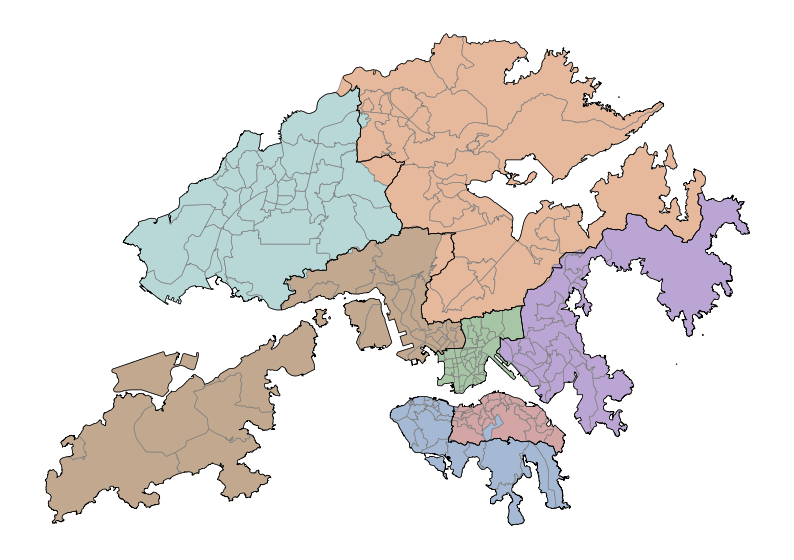

In [12]:
# Quick Check
fig, ax = plt.subplots(figsize=(10, 10))
for name, grp in tpu_final.groupby('cluster'):
    color = cluster_colors.get(name.lower(), 'lightgrey')
    grp.plot(
        ax=ax,
        facecolor=color,
        edgecolor='grey',
        linewidth=0.5,
        label=name
    )
cluster.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

Minor discrepancies were observed between the cluster boundaries derived from TPU-based and district-based dissolves. These differences may affect the visual appearance of the flow estimation maps, but they do not influence the methodological consistency or the substantive findings of this study.

### 1.3. Population-weighted Centroids

#### 1.3.1. Population Residual Allocation

In [13]:
# Assign ssbg to tpu
ssbg_tpu = (
    gpd.sjoin(
    ssbg_clean[["ssbg","t_pop","geometry"]],
    tpu_final[["stpug","geometry"]],
    how = "left",
    predicate = "within")
.drop(columns='index_right')
)
# Find the ssbg polygons that overlaps with more than one tpu polygons
ssbg_na = ssbg_tpu[ssbg_tpu['stpug'].isna()] #7 ssbgs

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2212564017.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2212564017.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


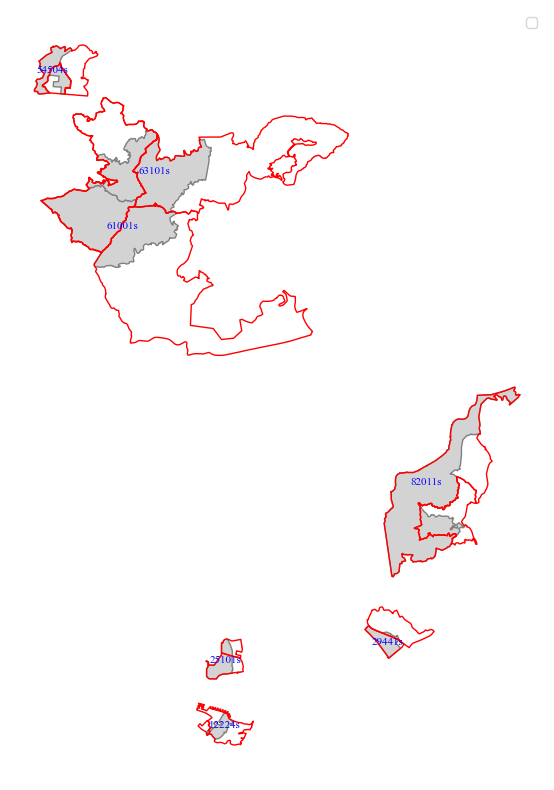

In [14]:
# Quick check for overlapped ssbg polygons
# Find the tpu that overlaps with ssbg
tpu_cut = gpd.sjoin(
    tpu_final,
    ssbg_na,
    how="inner",
    predicate="overlaps" 
)
fig, ax = plt.subplots(figsize=(10, 10))
# plot the two layers
ssbg_na.plot(ax=ax, color='lightgray', edgecolor='grey', label='ssbg_na (Polygons)')
tpu_cut.plot(ax=ax, facecolor='none', edgecolor='red')
# annotate each ssbg_na polygon with its 'ssbg' value
for _, row in ssbg_na.iterrows():
    point = row.geometry.representative_point()
    ax.text(
        point.x, point.y,
        row['ssbg'],
        fontsize=8,
        ha='center', va='center',
        color='blue'
    )
plt.legend()
ax.set_aspect('equal')
plt.axis('off')
plt.show()

In [15]:
# Split ssbg (Type 1 & Type 2)
split_ssbg_na = gpd.overlay(
        ssbg_na[["ssbg","geometry"]],
        tpu_final[["stpug","geometry"]],
        how='intersection',
        keep_geom_type=True
    )
# Dissolve ssbgs (Type 2)
split_ssbg_na = split_ssbg_na.dissolve(by=['stpug'], as_index=False)

In [16]:
# Calculate tpu population residuals
known_pop = ssbg_tpu.groupby('stpug')['t_pop'].sum().reset_index(name='t_pop_known')
tpu_final = tpu_final.merge(known_pop, on='stpug', how='left')
tpu_final['t_pop_resi'] = tpu_final['2021'] - tpu_final['t_pop_known']
# Redistribute ssbg population by tpu residuals 
split_ssbg_na = split_ssbg_na.merge(
    tpu_final[['stpug', 't_pop_resi']],
    on='stpug', how='left'
)

In [17]:
# Add redistributed data 
# unified code
split_ssbg_na['ssbg_index'] = (
    split_ssbg_na
    .groupby('ssbg')
    .cumcount()
    .map(lambda i: chr(65 + i))
)
split_ssbg_na['ssbg_code'] = split_ssbg_na['ssbg'] + split_ssbg_na['ssbg_index']
split_ssbg_na = split_ssbg_na[["ssbg_code","t_pop_resi","geometry","stpug"]]
split_ssbg_na = split_ssbg_na.rename(columns={
    'ssbg_code': 'ssbg',
    't_pop_resi': 't_pop'
})
# drop original ssbg
ssbg_tpu = ssbg_tpu.dropna()
# new ssbg gpd
ssbg_pop_final = pd.concat([ssbg_tpu, split_ssbg_na], ignore_index=True)

In [18]:
# Check the result 
print(f"Total number of ssbg_pop_final: {ssbg_pop_final['t_pop'].sum()}")
print(f"Total number of ssbg_clean: {ssbg_clean['t_pop'].sum()}")
print(f"Total number of tpu_final: {tpu_clean['2021'].sum()}")

Total number of ssbg_pop_final: 7379170.0
Total number of ssbg_clean: 7379170.0
Total number of tpu_final: 7379170.0


### 1.3.2 Population-weighted centroids calculation

In [19]:
# Function 1: weighted centroid
def weighted_centroid(gdf, group_col='stpug', weight_col='t_pop'):
    gdf = gdf.copy()
    gdf['centroid'] = gdf.geometry.centroid
    gdf['centroid_x'] = gdf['centroid'].x
    gdf['centroid_y'] = gdf['centroid'].y
    df = gdf[[group_col, 'centroid_x', 'centroid_y', weight_col]].copy().set_index(group_col)
    weighted = (
        df.groupby(group_col)
        .apply(lambda g: pd.Series({
            'weighted_x': (g['centroid_x'] * g[weight_col]).sum() / g[weight_col].sum(),
            'weighted_y': (g['centroid_y'] * g[weight_col]).sum() / g[weight_col].sum()
        }))
        .reset_index()
    )
    weighted['geometry'] = weighted.apply(lambda row: Point(row['weighted_x'], row['weighted_y']), axis=1)
    cent = weighted[["stpug","geometry"]]
    return gpd.GeoDataFrame(cent, geometry='geometry', crs=gdf.crs)

# Function 2: Fixed centroid out of polygon
def fix_cent(points_gdf, polygon_gdf):
    joined = gpd.sjoin(points_gdf, polygon_gdf[['geometry']], predicate='within', how='left')
    outside_mask = joined['index_right'].isna()
    poly_union = polygon_gdf.geometry.union_all()
    points_fixed = points_gdf.copy()
    points_fixed.loc[outside_mask, 'geometry'] = points_fixed.loc[outside_mask, 'geometry'].apply(
        lambda pt: nearest_points(pt, poly_union)[1]
    )
    return points_fixed

In [20]:
# Calculate the weighted centroid of TPUs
tpu_cent1 = weighted_centroid(ssbg_pop_final, group_col='stpug', weight_col='t_pop')

In [21]:
# Quick check for centroids out of TPUs' boundaries
joined = gpd.sjoin(tpu_cent1, tpu_clean[['geometry']], predicate='within', how='left')
outside_mask = joined['index_right'].isna()
outside_points = joined[outside_mask].copy()

In [22]:
# Assign the nearest point of tpu boudary to TPU centroid
tpu_cent_final = fix_cent(tpu_cent1, tpu_final)

/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


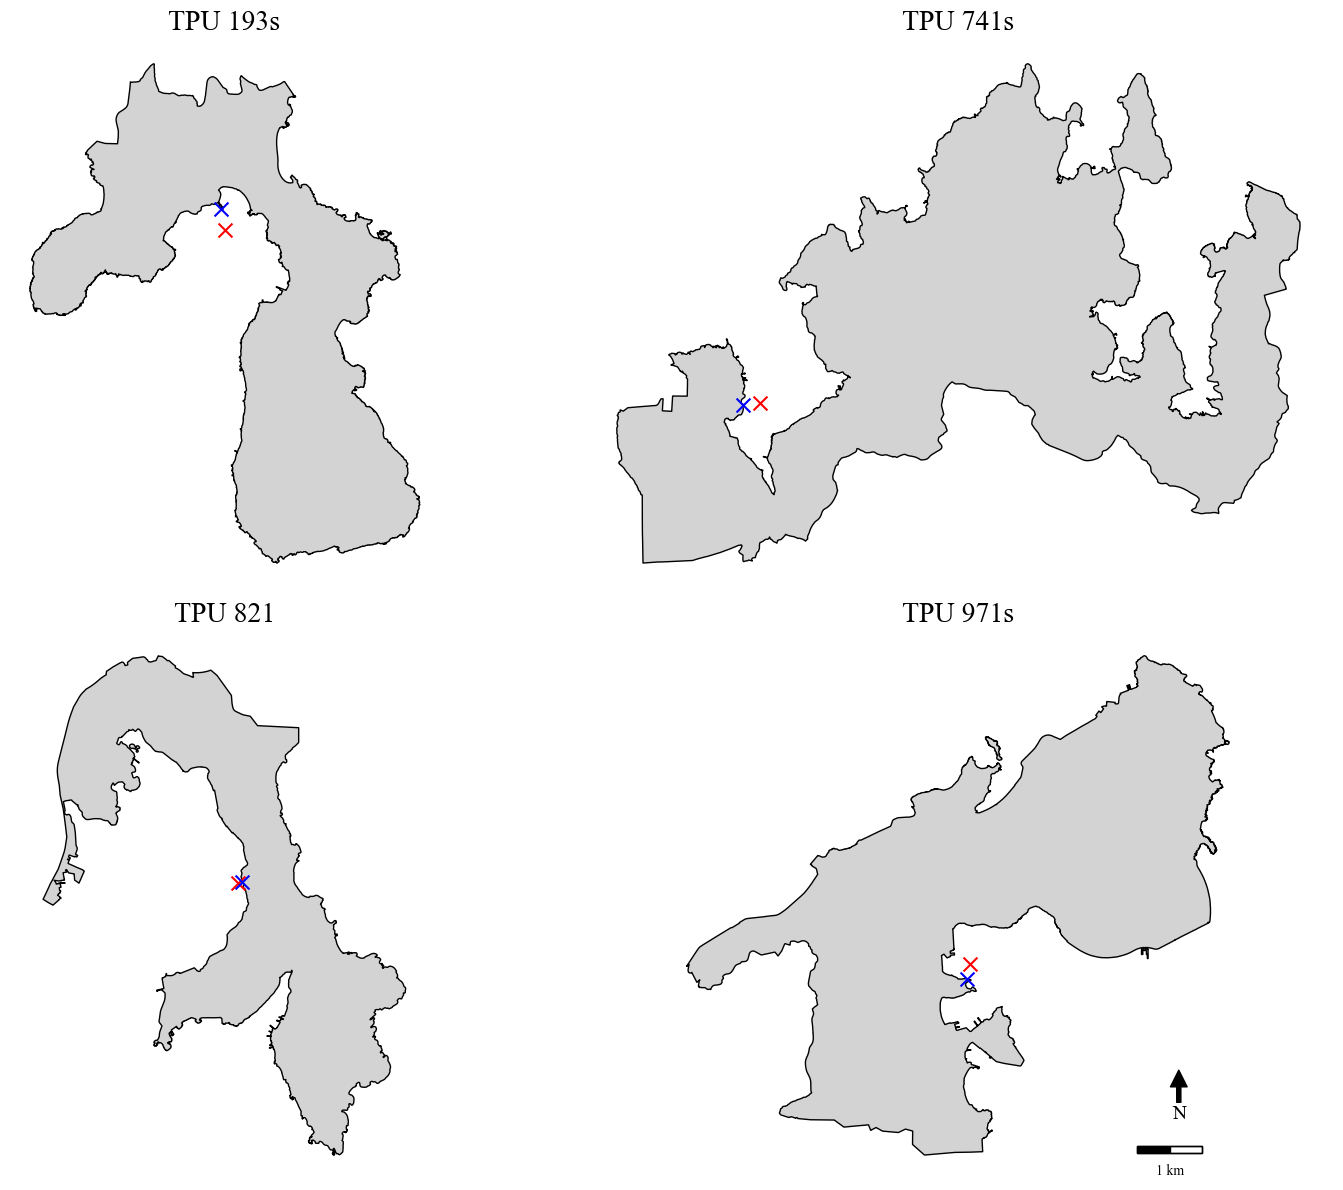

In [23]:
# Visualize the adjustment 
target_stpugs = ["193s", "741s", "821", "971s"]
outside_tpu = tpu_final[tpu_final["stpug"].isin(target_stpugs)]
outside_fixed_points = tpu_cent_final[tpu_cent_final["stpug"].isin(target_stpugs)]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, stpug in enumerate(target_stpugs):
    ax = axes[i]
    tpu_poly = tpu_final[tpu_final["stpug"] == stpug]
    raw_pts = joined[joined["stpug"] == stpug] if "stpug" in joined.columns else joined
    outside_pts = raw_pts[outside_mask]
    fixed_pts = tpu_cent_final[tpu_cent_final["stpug"] == stpug]
    tpu_poly.plot(ax=ax, color="lightgrey", edgecolor="black")   
    if not outside_pts.empty:
        outside_pts.plot(
            ax=ax, color="red", markersize=100,marker="x")  
    if not fixed_pts.empty:
        fixed_pts.plot(
            ax=ax, color="blue", markersize=100,marker="x")

    ax.set_title(f"TPU {stpug}", fontsize=20)
    ax.axis("off")

plt.tight_layout()
add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
add_scale_bar(ax,length=1000,location=(0.8, 0.05)) 
#plt.savefig('./fixed_centroids.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.4. Travel Time matrix

#### 1.4.1. Construct Road network Multi-DiGraph

In [24]:
# Function:Convert a GeoDataFrame of road segments into a directed graph using NetworkX.
def gdf_to_digraph(gdf):
    G = nx.MultiDiGraph()
    
    for _, row in gdf.iterrows():
        geometry = row['geometry']
        route_id = row['route_id']
        direction = row['travel_direction']
        time_cost = row['time_cost_min']
        speed_limit = row["km_hr"]
        lines = geometry.geoms if isinstance(geometry, MultiLineString) else [geometry]
        
        for line in lines:
            coords = list(line.coords)
            start_xy = coords[0]
            end_xy = coords[-1]

            start_id = f"{round(start_xy[0],1)}_{round(start_xy[1],1)}" #round to 1 decimal digit ~ 0.1m error
            end_id = f"{round(end_xy[0],1)}_{round(end_xy[1],1)}"#round to 1 decimal digit ~ 0.1m error

            if start_id not in G.nodes:
                G.add_node(start_id, x=start_xy[0], y=start_xy[1])
            if end_id not in G.nodes:
                G.add_node(end_id, x=end_xy[0], y=end_xy[1])

            if direction == 1:
                G.add_edge(start_id, end_id, route_id=route_id, weight=time_cost, speed_limit=speed_limit)
                G.add_edge(end_id, start_id, route_id=route_id, weight=time_cost, speed_limit=speed_limit)
            elif direction == 3:
                G.add_edge(start_id, end_id, route_id=route_id, weight=time_cost, speed_limit=speed_limit)

    G.graph["crs"] = gdf.crs
    return G

In [25]:
# Check speed data
print(road_nw["km_hr"].value_counts())

km_hr
50.0     32338
70.0      2198
80.0      1229
100.0      462
30.0       282
110.0       78
Name: count, dtype: int64


In [26]:
# Calculate the length of each road segment (in meters, since EPSG:2326 is in meters)
road_nw["length"] = road_nw.geometry.length
# Convert length from meters to kilometers
road_nw["length_km"] = road_nw["length"] / 1000
# Calculate estimated travel time (in minutes) for each segment
road_nw["time_cost_min"] = (road_nw["length_km"] / road_nw["km_hr"]) * 60

In [27]:
# Construct the road network
G = gdf_to_digraph(road_nw)

In [28]:
# Quick check
# Number of nodes & edges
print(f"Total number of nodes in G: {len(G.nodes())}")
print(f"Total number of edges in G: {len(G.edges())}") # Due to the original data are in Multipolyline format, there are more edges in G. 
# Connectivity
sccs = list(nx.strongly_connected_components(G))
lscc = max(sccs, key=len)
print(f"Number of strongly connected components: {len(sccs)}")
print(f"Largest strongly connected component size: {len(lscc)} nodes")
print(f"There are {(len(lscc)/len(G.nodes()))*100}% in lscc")

Total number of nodes in G: 26696
Total number of edges in G: 47981
Number of strongly connected components: 570
Largest strongly connected component size: 26103 nodes
There are 97.77869343721906% in lscc


In [29]:
# Filter out lscc as the final road network
G_clean = G.subgraph(lscc).copy()

#### 1.4.2. Find the nearest node

In [30]:
# find the nearest node from TPU centroid
tpu_cent_final['x'] = tpu_cent_final.geometry.x
tpu_cent_final['y'] = tpu_cent_final.geometry.y
tpu_cent_final['node'] = ox.nearest_nodes(G_clean, tpu_cent_final['x'], tpu_cent_final['y'])
# find the nearest node of hospital 
hosp['x'] = hosp.geometry.x
hosp['y'] = hosp.geometry.y
hosp['node'] = ox.nearest_nodes(G_clean, hosp['x'], hosp['y'])

#### 1.4.3. Calculate the shortest path

In [31]:
# Function: shortest path from centroids to all nodes
def compute_shortest_path(gdf_centroids, G, centroid_col = "node", weight_col = "weight"):
    # nodes index
    nodes = list(G.nodes())
    node_to_idx = {n: i for i, n in enumerate(nodes)}
    idx_to_node = {i: n for n, i in node_to_idx.items()}
    N = len(nodes)

    # matrix
    rows, cols, data = [], [], []
    for u, v, attr in G.edges(data=True):
        if weight_col in attr:
            weight = attr[weight_col]
        else:
            raise KeyError(f"Edge ({u}, {v}) is missing weight '{weight_col}'")
        rows.append(node_to_idx[u])
        cols.append(node_to_idx[v])
        data.append(weight)

    A = csr_matrix((data, (rows, cols)), shape=(N, N))

    # multisource matrix
    centroids = gdf_centroids[centroid_col].to_numpy()
    centroid_indices = [node_to_idx[c] for c in centroids]
    dist_matrix = dijkstra(csgraph=A, directed=True, indices=centroid_indices)

    # output
    records = (
        (centroids[i], idx_to_node[j], dist_matrix[i, j])
        for i in range(len(centroids))
        for j in range(N)
        if not np.isinf(dist_matrix[i, j])
    )

    df = pd.DataFrame.from_records(
        records, columns=['source', 'target', 'travel_time_min']
    )

    return df

In [32]:
# Calculate the shortest path from tpu centroids to all nodes
tpu_path = compute_shortest_path(tpu_cent_final, G_clean, centroid_col='node', weight_col='weight')

In [33]:
# Filtered out the shortest path from tpu to hospitals
tpu_hosp = tpu_path[tpu_path['target'].isin(hosp['node'])]

In [34]:
# convert it into od matrix
tpu_hosp_matrix = tpu_hosp.pivot_table(
    index='source',
    columns='target',
    values='travel_time_min',
    aggfunc='min'
)

In [35]:
# Rename 
# hospital
node2facility = hosp.set_index('node')['hosp'].to_dict()
tpu_hosp_matrix = tpu_hosp_matrix.rename(columns=node2facility)
# tpu
trav_time = tpu_cent_final.merge(
    tpu_hosp_matrix,
    left_on='node',
    right_on='source',
    how='left'
)

In [36]:
# drop unnecessary columns
# travel cost
cols_to_drop_trav = ['geometry', '2023','2027','2036','x', 'y', 'node']
trav_time_final = trav_time.drop(columns=cols_to_drop_trav, errors='ignore')
# tpu_cent & hosp (points)
cols_to_drop_tpu_hosp = ['x', 'y', 'node']
tpu_cent_final = tpu_cent_final.drop(columns=cols_to_drop_tpu_hosp, errors='ignore')
hosp_final = hosp.drop(columns=cols_to_drop_tpu_hosp, errors='ignore')
# tpu_final (polygons)
tpu_final = tpu_final[["stpug","cluster","2021","2023","2027","2036","geometry"]]

### 1.5. Show the data

Clean Dataframe: 
- hosp_final: hospital information
- tpu_cent_final: population centroids
- tpu_final: population by tpu (2021, 2023, 2027 and 2036)
- ssbg_pop_final: population by ssbg (2021)
- trav_time_final: travel time matrix
- road_nw: clean road network 
- cluster: cluster boundaries based on district boudnaries

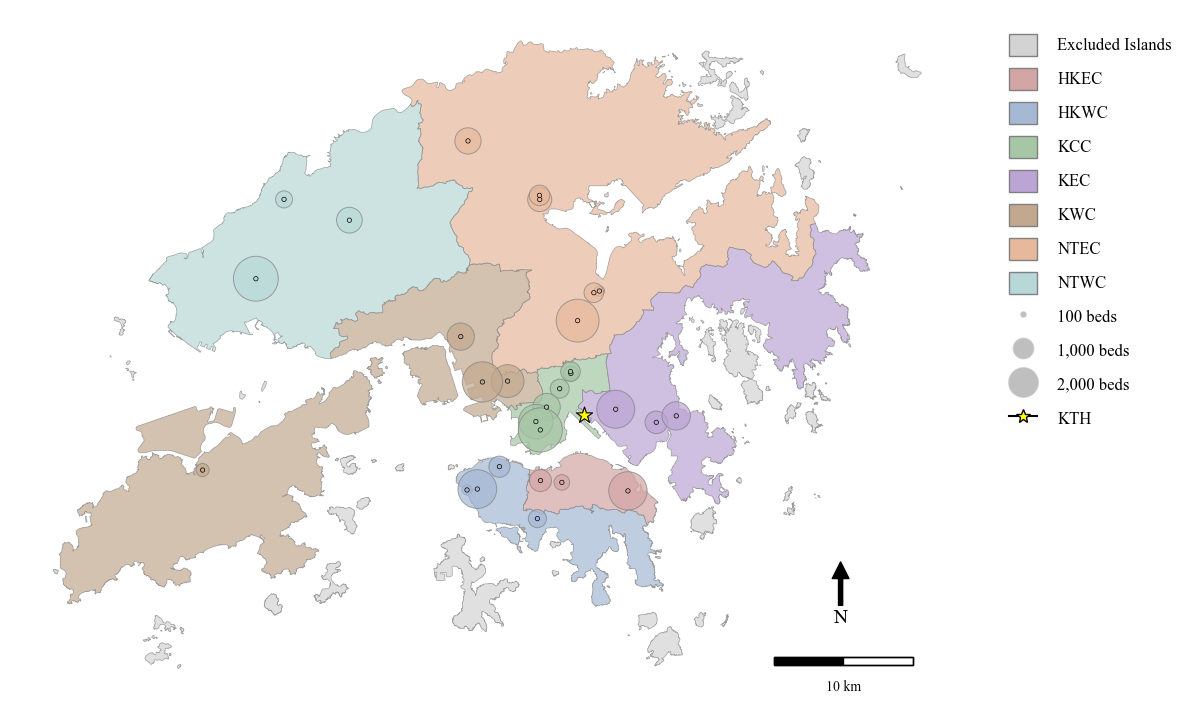

In [37]:
# Figure: Hospital Distribution
fig, ax = plt.subplots(figsize=(12, 10))
# islands
islands.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7, linewidth=0.5, zorder=1)
# cluster
cluster.plot(
    ax=ax,
    color=cluster['cluster'].map(cluster_colors),
    edgecolor='grey',
    alpha=0.7,
    linewidth=0.5,
    zorder=2
)

# number of beds
hosp_final.plot(
    ax=ax,
    color=hosp_final['cluster'].map(cluster_colors),
    markersize=hosp_final['t_2023']*0.5,
    alpha=0.7,
    edgecolor='grey',
    linewidth=0.7,
    zorder=3
)

# hospital location
hosp_final.plot(
    ax=ax,
    color=hosp_final['cluster'].map(cluster_colors),
    markersize=10,
    edgecolor='black',
    linewidth=0.5,
    zorder=4
)

# Kai Tak
for i, row in hosp_final.iterrows():
    if row['hosp'].lower() == 'kai tak hospital':
        ax.scatter(
            row.geometry.x, row.geometry.y,
            marker='*',
            s=150,
            facecolor='yellow',
            edgecolor='black',
            linewidth=0.8,
            zorder=5,
            label='Kai Tak Hospital'
        )

# Legend
cluster_legend = [
    Patch(facecolor='lightgrey', edgecolor='grey', label='Excluded Islands') 
] + [
    Patch(facecolor=color, edgecolor='grey', label=format_label(name, abbrev=True))
    for name, color in cluster_colors.items()
]

size_legend = [
    Line2D([0], [0], marker='o', color='w', label='100 beds',
           markerfacecolor='grey', markersize=np.sqrt(100) * 0.5, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='1,000 beds',
           markerfacecolor='grey', markersize=np.sqrt(1000) * 0.5, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='2,000 beds',
           markerfacecolor='grey', markersize=np.sqrt(2000) * 0.5, alpha=0.5)
]

special_legend = [
    Line2D([0], [0], marker='*', color='black', label='KTH',
           markerfacecolor='yellow', markersize=10),
]

final_legend = cluster_legend + size_legend + special_legend


leg =ax.legend(
    handles=final_legend,
    bbox_to_anchor=(1.02, 1), 
    loc='upper left',
    frameon=False,
    handleheight=2,
    labelspacing=0.9,
    borderpad=1.3,
    handletextpad=1.5,
    columnspacing=1.5
)
for text in leg.get_texts():
    text.set_fontsize(12)

ax.axis('off')
plt.subplots_adjust(right=0.5)
plt.tight_layout()
add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
add_scale_bar(ax,length=10000,location=(0.8, 0.05)) 
#plt.savefig('./hospital_cluster_map.png', dpi=300, bbox_inches='tight')
plt.show()

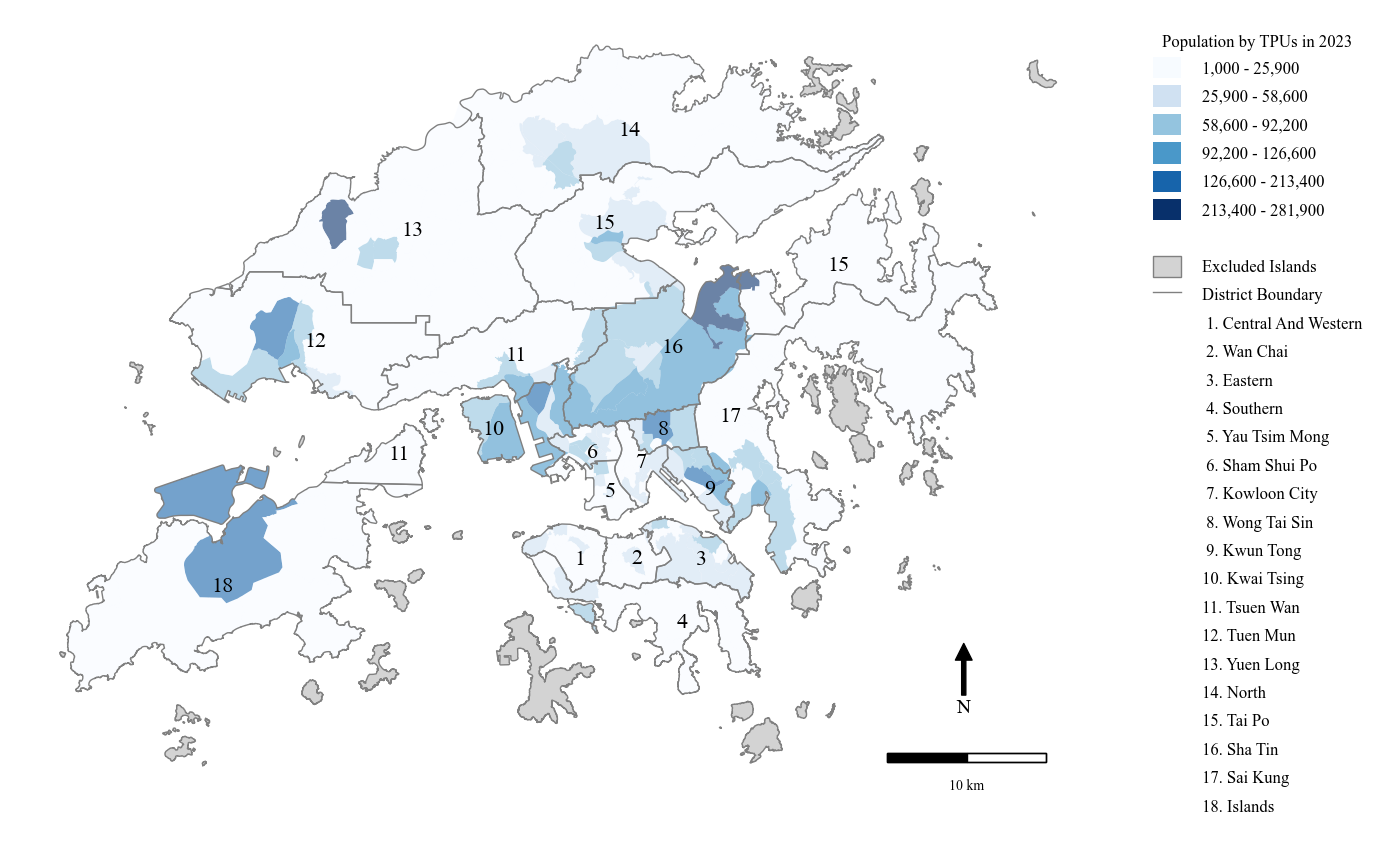

In [ ]:
# Figure: TPU Population distribution in 2023
# Natural Breaks
nb = mapclassify.NaturalBreaks(tpu_clean['2023'], k=6)
bins = [int(round(tpu_clean['2023'].min()))] + [int(round(b)) for b in nb.bins]

# colormap
cmap = plt.cm.Blues
norm = mcolors.BoundaryNorm(bins, cmap.N)
colors = [cmap(norm((bins[i] + bins[i+1]) / 2)) for i in range(len(bins)-1)]

fig, ax = plt.subplots(figsize=(14, 12)) 

# Islands
islands.plot(ax=ax, color='lightgrey', edgecolor='none', zorder=1)

# TPU population
tpu_clean.plot(
    ax=ax,
    column='2023',
    cmap=cmap,
    norm=norm,
    legend=False,
    alpha=0.6,
    edgecolor='none',
    zorder=2
)

# District 
district.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    linewidth=1,
    zorder=3
)
district['dc_id'] = range(1, len(district) + 1)
# district labels
label_twice_ids = [11, 15]

for idx, row in district.iterrows():
    geom = row.geometry
    label = str(row['dc_id'])

    point = geom.representative_point()
    ax.text(
        point.x,
        point.y,
        label,
        fontsize=16,
        fontname='Times New Roman',
        ha='center',
        va='center',
        color='black',
        zorder=4
    )

    if row['dc_id'] in label_twice_ids and isinstance(geom, MultiPolygon):
        sorted_parts = sorted(geom.geoms, key=lambda g: g.area, reverse=True)
        if len(sorted_parts) >= 2:
            second_largest = sorted_parts[1]
            point2 = second_largest.representative_point()
            ax.text(
                point2.x,
                point2.y,
                label,
                fontsize=16,
                fontname='Times New Roman',
                ha='center',
                va='center',
                color='black',
                zorder=4
            )
district_sorted = district.sort_values('dc_id')
district_labels = [
    Line2D(
        [0], [0],
        color='none',
        label=f"{row['dc_id']:>2}. {format_label(row['dc_eng'])}"
    )
    for idx, row in district_sorted.iterrows()
]

# legend
pop_patches = [Patch(facecolor=colors[i], edgecolor='none',
                     label=f"{bins[i]:,} - {bins[i+1]:,}")
               for i in range(len(colors))]

empty_patch = Patch(facecolor='none', edgecolor='none', label="")

# Islands 
island_legend = Patch(facecolor='lightgrey', edgecolor='grey', label='Excluded Islands') 
# District Boundary
dist_line = Line2D([0], [0], color='grey', linewidth=1, label='District Boundary')

all_handles = pop_patches + [empty_patch, island_legend, dist_line] + district_labels

leg = ax.legend(
    handles=all_handles,
    bbox_to_anchor=(1.02, 1), 
    loc='upper left',
    title="Population by TPUs in 2023",
    frameon=False,
    handleheight=2,
    labelspacing=0.5,
    borderpad=1.3,
    handletextpad=1.5,
    columnspacing=1.5
)

for text in leg.get_texts():
    text.set_fontsize(12)
    text.set_ha('left')
leg.get_title().set_fontsize(12)
ax.axis('off')
plt.tight_layout()
add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
add_scale_bar(ax,length=10000,location=(0.8, 0.05)) 
#plt.savefig('./population distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [155]:
tpu_clean.describe()

,2021,2023,2027,2036,pop_change
count,208.000000,208.000000,208.000000,208.0000,208.000000
mean,35476.778846,35888.750000,36571.442308,38410.6250,2521.875000
std,41300.634285,42055.529732,43235.074438,45408.5021,8554.330095
min,1106.000000,1000.000000,1100.000000,1156.0000,-4421.000000
25%,7980.500000,7900.000000,7850.000000,8245.5000,-196.750000
50%,18781.500000,18400.000000,18700.000000,19641.0000,159.000000
75%,53639.500000,54000.000000,53825.000000,56531.2500,1833.250000
max,277731.000000,281900.000000,278200.000000,292186.0000,83221.000000


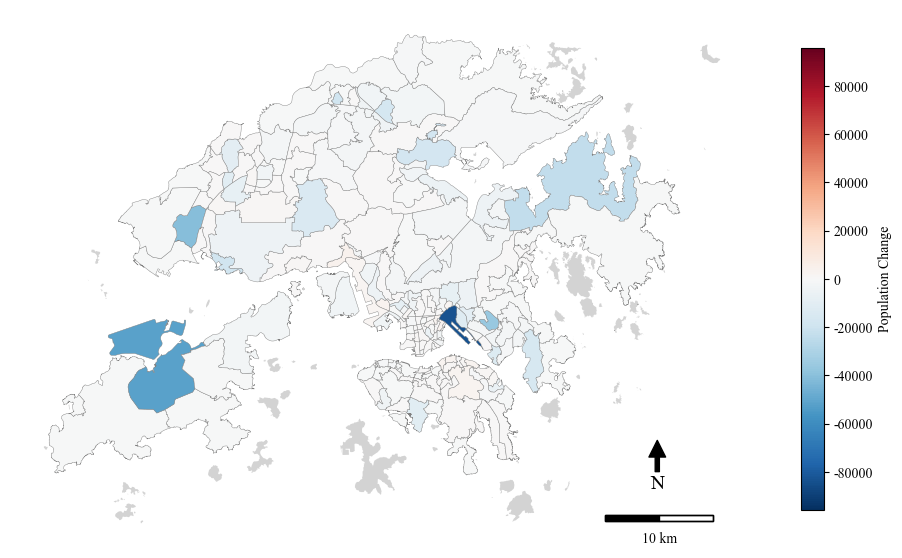

In [153]:
# Figure: Population change between 2023 and 2036
fig, ax = plt.subplots(figsize=(12, 10))
# Islands
islands.plot(ax=ax, color='lightgrey', edgecolor='none', zorder=1)
# max value 
abs_max = 95746

# Set 0 as the center
norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

# plot
tpu_clean_plot = tpu_clean.plot(
    column='pop_change',
    cmap='RdBu',
    linewidth=0.3,
    edgecolor='grey',
    ax=ax,
    norm=norm,
    legend=False
)

# colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)

ticks = np.arange(-80000, 80001, 20000)
cbar.set_ticks(ticks)
cbar.set_label('Population Change')

cbar.ax.set_yticklabels([f'{int(t)}' for t in ticks])

ax.axis('off')
add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
add_scale_bar(ax,length=10000,location=(0.8, 0.05)) 
plt.savefig('./population_change.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Data Analysis

Key dataframe for analysis:
- tpu_final: population
- hosp_final: hospital information
- trav_time_final: travel time matrix

In [40]:
# Define component
# Population
pop_ai = tpu_final.set_index('stpug').copy()
# Hospital 
hosp_ai = hosp_final.set_index('hosp').copy()
# Travel Time
trav_time_ai_27 = trav_time_final.set_index('stpug') # 2028 hospital layout
trav_time_ai_23 = trav_time_ai_27.drop(columns=["kai tak hospital"]).copy() # 2023 hospital layout

### 2.1. MH3FSCA

#### 2.1.1. Wij & Pij

In [41]:
# Function 1: Wij 
def wij_func(trav_df, tmax=35, alpha=11.13, beta=2.14):
    """
    Inputs:
        trav_df (DataFrame): Travel time matrix (TPU × Hospital)  
    Formula:
        W_{ij} = {
            0,                             if t_{ij} > t_max  
            1 / [1 + (t_{ij} / alpha)^beta],     if t_{ij} ≤ t_max  
        }

    where
        t_{ij}: Travel time from TPU i to hospital j  
        t_max: Maximum travel time threshold defining the catchment area  
        alpha, beta: Parameters that control the shape of the decay curve  
        W_{ij}: Distance-decay weight between TPU i and hospital j
    """
    # df to numpy
    trav_arr = trav_df.to_numpy(dtype=float)
    # calculate 
    w = np.where(trav_arr > tmax, 0.0, 1.0 / (1.0 + (trav_arr / alpha) ** beta))
    # return the result as df
    wij = pd.DataFrame(w, index=trav_df.index, columns=trav_df.columns)
    return wij

# Function 2a: Pij
def pij_func(wij_df, trav_df, hosp_df, supply_col="t_2023"):
    """
    Inputs:
        wij_df (DataFrame): Precomputed distance-decay weight matrix (W_{ij})  
        trav_df (DataFrame): Travel time matrix (TPU × Hospital), used for index/column alignment  
        hosp_df (DataFrame): Hospital attribute table, including supply data  
        supply_col (str): Column name in `hosp_df` containing bed supply values (S_j)

    Formula:
        A_{ij} = S_j · W_{ij}  
        P_{ij} = A_{ij} / Σ_j A_{ij}

    where
        S_j: Number of beds in hospital j  
        W_{ij}: Distance-decay weight between TPU i and hospital j  
        A_{ij}: Attractiveness of hospital j from the perspective of TPU i  
        P_{ij}: Probability that a resident from TPU i chooses hospital j
    """
    # Align S_j with columns (hospitals) in trav_df
    supply = hosp_df[supply_col].reindex(trav_df.columns)
    # A_{ij} = S_j × W_{ij}
    aij = wij_df.mul(supply, axis=1)
    # ∑_j A_{ij}
    denom = aij.sum(axis=1).replace(0, np.nan)
    # P_{ij}= A_{ij} / ∑_j A_{ij}
    pij = aij.div(denom, axis=0).fillna(0.0)
    return pij

# Function 2b: Estimate flow at Cluster level 
def cal_flows_cluster(pij_df, pij_cols, pop_col='2023',
                    tpu_cluster_col='cluster_tpu',
                    hosp_cluster_col='cluster_hosp'):
    df = pij_df.copy()
    flow_cols = [f"{col}_flow" for col in pij_cols]

    # Pij x pop
    for col in pij_cols:
        df[f"{col}_flow"] = df[col] * df[pop_col]

    # Aggregate flows
    pij_cluster = (
        df.groupby([tpu_cluster_col, hosp_cluster_col])[flow_cols]
        .sum()
        .reset_index()
    )
    pij_cluster.rename(columns={col: col.replace('_flow', '') for col in flow_cols}, inplace=True)

    return pij_cluster

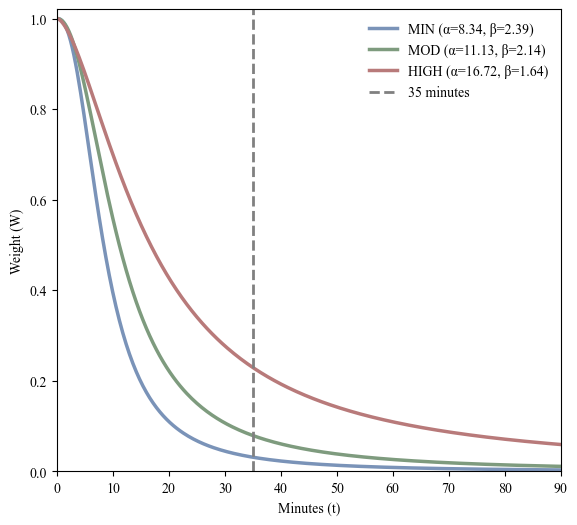

In [42]:
# Figure: Distance decay function 
def W(d, alpha, beta):
    d = np.asarray(d, dtype=float)
    return 1.0 / (1.0 + (d / alpha) ** beta)

d = np.linspace(0, 90, 300)

params = {
    "MIN":  (8.34,  2.39, '#7A93B8'), 
    "MOD":  (11.13, 2.14, '#7E9B7E'),
    "HIGH": (16.72, 1.64, '#B87A7A'),
}
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(6.5, 6))
for name, (a, b, color) in params.items():
    ax.plot(d, W(d, a, b), label=f"{name} (α={a:g}, β={b:g})", color=color, linewidth=2.5)
line35 = ax.axvline(35, linestyle="--", linewidth=2, color='gray', label="35 minutes")

ax.set_xlabel("Minutes (t)")
ax.set_ylabel("Weight (W)")
ax.set_xlim(0, 90)
ax.set_ylim(0, 1.02)
ax.set_xticks(np.arange(0, 91, 10))

#ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="upper right", frameon=False)

#plt.savefig("distance_decay.png", dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Find the minimum distance from the furthest tpu to its nearest hospital
min_values = trav_time_ai_27.min(axis=1)
min_values.describe() # thus, we set 35 mintues as the catchment area for sensitivity analysis


count    208.000000
mean       4.501064
std        4.303876
min        0.069848
25%        1.974583
50%        3.211554
75%        5.204428
max       30.675738
dtype: float64

In [44]:
# Find the maximum distance from the furthest tpu to its nearest hospital
max_values = trav_time_ai_27.max(axis=1)
max_values.describe() # thus, we set 75 mintues as the catchment area for sensitivity analysis

count    208.000000
mean      41.315603
std        7.088210
min       27.070737
25%       36.228379
50%       40.542005
75%       45.910159
max       70.213629
dtype: float64

In [45]:
# Calculation
# Wij
# 2023 (Scenario 1)
wij23_35_min = wij_func(trav_time_ai_23, tmax=35, alpha=8.34, beta=2.39)
wij23_35_mod = wij_func(trav_time_ai_23, tmax=35, alpha=11.13, beta=2.14)
wij23_35_high = wij_func(trav_time_ai_23, tmax=35, alpha=16.72, beta=1.64)
wij23_75_min = wij_func(trav_time_ai_23, tmax=75, alpha=8.34, beta=2.39)
wij23_75_mod = wij_func(trav_time_ai_23, tmax=75, alpha=11.13, beta=2.14)
wij23_75_high = wij_func(trav_time_ai_23, tmax=75, alpha=16.72, beta=1.64)
# 2027 (Scenario 2 & 3)
wij27_35_min = wij_func(trav_time_ai_27, tmax=35, alpha=8.34, beta=2.39)

# Pij
# 2023 (Scenario 1)
pij23_35_min = pij_func(wij23_35_min, trav_time_ai_23, hosp_ai, supply_col="t_2023")
pij23_35_mod = pij_func(wij23_35_mod, trav_time_ai_23, hosp_ai, supply_col="t_2023")
pij23_35_high = pij_func(wij23_35_high, trav_time_ai_23, hosp_ai, supply_col="t_2023")
pij23_75_min = pij_func(wij23_75_min, trav_time_ai_23, hosp_ai, supply_col="t_2023")
pij23_75_mod = pij_func(wij23_75_mod, trav_time_ai_23, hosp_ai, supply_col="t_2023")
pij23_75_high = pij_func(wij23_75_high, trav_time_ai_23, hosp_ai, supply_col="t_2023")
# 2027 (Scenario 2)
pij27_35_min = pij_func(wij27_35_min, trav_time_ai_27, hosp_ai, supply_col="t_2028")
# 2036 (Scenario 3)
pij36a_35_min = pij_func(wij27_35_min, trav_time_ai_27, hosp_ai, supply_col="t_2036a")


In [46]:
# Merge Pij with tpu_final
#pij
pij_dfs = [
    ('pij23_35_min', pij23_35_min),
    ('pij23_35_mod', pij23_35_mod),
    ('pij23_35_high', pij23_35_high),
    ('pij23_75_min', pij23_75_min),
    ('pij23_75_mod', pij23_75_mod),
    ('pij23_75_high', pij23_75_high),
    ('pij27_35_min', pij27_35_min),
    ('pij36a_35_min', pij36a_35_min)
]

# melt->long form
melted_dfs = []
for name, df in pij_dfs:
    melted = df.reset_index().melt(
        id_vars='stpug',
        var_name='hosp',
        value_name=name
    )
    melted_dfs.append(melted)

pij = reduce(
    lambda left, right: pd.merge(left, right, on=['stpug', 'hosp'], how='outer'),
    melted_dfs
)

In [47]:
# Add cluster and population information 
pij_final = (
    pij
    .merge(hosp_final[["hosp", "cluster"]], on="hosp", how="left")
    .rename(columns={"cluster": "cluster_hosp"})
    .merge(tpu_final[["stpug", "cluster","2023","2027","2036"]], on="stpug", how="left")
    .rename(columns={"cluster": "cluster_tpu"})
    .copy()
)

In [48]:
# Quick check
pij_final

,stpug,hosp,pij23_35_min,pij23_35_mod,pij23_35_high,pij23_75_min,pij23_75_mod,pij23_75_high,pij27_35_min,pij36a_35_min,cluster_hosp,cluster_tpu,2023,2027,2036
0,111,alice ho miu ling nethersole hospital,0.003258,0.005797,0.011991,0.003219,0.005668,0.011401,0.002890,0.002407,new territories east cluster,hong kong west cluster,57500.0,55400.0,58186
1,111,caritas medical centre,0.055042,0.060873,0.060630,0.054379,0.059521,0.057647,0.048828,0.058787,kowloon west cluster,hong kong west cluster,57500.0,55400.0,58186
2,111,"cheshire home, shatin",0.001462,0.002230,0.003449,0.001444,0.002181,0.003280,0.001297,0.001080,new territories east cluster,hong kong west cluster,57500.0,55400.0,58186
3,111,grantham hospital,0.024723,0.023938,0.021012,0.024425,0.023407,0.019978,0.028401,0.053287,hong kong west cluster,hong kong west cluster,57500.0,55400.0,58186
4,111,haven of hope hospital,0.008173,0.012105,0.017803,0.008075,0.011836,0.016928,0.007250,0.009949,kowloon east cluster,hong kong west cluster,57500.0,55400.0,58186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,975,tung wah eastern hospital,0.007236,0.008184,0.009439,0.007236,0.008184,0.009439,0.006014,0.004777,hong kong east cluster,kowloon west cluster,14100.0,13400.0,14074
6236,975,tung wah group of hospitals wong tai sin hospital,0.014995,0.016095,0.017000,0.014995,0.016095,0.017000,0.012463,0.017342,kowloon central cluster,kowloon west cluster,14100.0,13400.0,14074
6237,975,tung wah hospital,0.015240,0.016800,0.018545,0.015240,0.016800,0.018545,0.012667,0.010061,hong kong west cluster,kowloon west cluster,14100.0,13400.0,14074
6238,975,united christian hospital,0.040171,0.046070,0.054457,0.040171,0.046070,0.054457,0.045903,0.045335,kowloon east cluster,kowloon west cluster,14100.0,13400.0,14074


In [49]:
# Estiamte flows at cluster level for sensitivity analysis
# 2023
cols_pij23 = [
    'pij23_35_min', 'pij23_35_mod', 'pij23_35_high',
    'pij23_75_min', 'pij23_75_mod', 'pij23_75_high'
]
flows23_cluster = cal_flows_cluster(pij_final, cols_pij23, pop_col='2023')
#flows23_cluster.to_csv("flows23_cluster.csv", index=False)

In [50]:
# Visualization 
def plot_cluster_sankey(df, value_col, cluster_colors, cluster_order, title=None, value_scale=1):
    df = df.copy()
    df['cluster_tpu_label'] = 'TPU: ' + df['cluster_tpu']
    df['cluster_hosp_label'] = 'HOSP: ' + df['cluster_hosp']

    #cluster order
    tpu_labels = [f'TPU: {c}' for c in cluster_order]
    hosp_labels = [f'HOSP: {c}' for c in cluster_order]
    all_nodes = tpu_labels + hosp_labels
    node_mapping = {name: i for i, name in enumerate(all_nodes)}

    df['source'] = df['cluster_tpu_label'].map(node_mapping)
    df['target'] = df['cluster_hosp_label'].map(node_mapping)
    df['value'] = df[value_col] * value_scale

    # node colors
    def get_node_color(label):
        cluster_name = label.replace("TPU: ", "").replace("HOSP: ", "")
        return cluster_colors.get(cluster_name, '#CCCCCC')
    
    node_colors = [get_node_color(label) for label in all_nodes]

    # link colors (with transparency)
    max_val = df[value_col].max()
    def hex_to_rgba_with_alpha(hex_color, value, max_value):
        hex_color = hex_color.lstrip('#')
        r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
        alpha = max(min(value / max_value, 1), 0.15)
        return f'rgba({r},{g},{b},{alpha:.2f})'

    link_colors = [
        hex_to_rgba_with_alpha(cluster_colors[row['cluster_tpu']], row[value_col], max_val)
        for _, row in df.iterrows()
    ]
    
    # Sankey plot
    sankey_trace = go.Sankey(
        arrangement='fixed',
        node=dict(
            pad=40,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[""] * len(all_nodes), 
            color=node_colors,
        ),
        link=dict(
            source=df['source'],
            target=df['target'],
            value=df['value'],
            color=link_colors
        )
    )

    # legend
    legend_trace = go.Scatter(
        x=[None]*len(cluster_colors),
        y=[None]*len(cluster_colors),
        mode='markers',
        marker=dict(size=15, color=list(cluster_colors.values())),
        showlegend=True,
        name='',
        legendgroup='clusters',
        text=list(cluster_colors.keys()),
        hoverinfo='text'
    )

    legend_traces = [
        go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=12, color=color),
            name=format_label(cluster, abbrev=True)
        )
        for cluster, color in cluster_colors.items()
    ]

    # Layout + Layers
    fig = go.Figure(data=[sankey_trace] + legend_traces)

    fig.update_layout(
    title_text=title or value_col.replace('_', ' ').title(),
    width=1000,
    height=700,
    font_size=12,
    legend_title_text='Cluster',
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(visible=False),
    yaxis=dict(visible=False)
)

    fig.show()

In [51]:
# Figure: Sensitivity analysis (flows estimation) 
for col in cols_pij23:
    plot_cluster_sankey(flows23_cluster, col, cluster_colors, cluster_order)

#### 2.1.2. Rj & Ai

In [52]:
# Function 3: Rj
def rj_func(pij_df, pop_df, hosp_df, pop_col="2023", supply_col="t_2023"):
    """
    Inputs:
        pij_df (DataFrame): Precomputed Huff probability matrix (TPU × Hospital)  
        pop_df (DataFrame): Population data for each TPU  
        hosp_df (DataFrame): Hospital attribute data, including bed supply  
        pop_col (str): Column name in `pop_df` containing population counts (D_i)  
        supply_col (str): Column name in `hosp_df` containing bed supply (S_j)  

    Formula:
        D_j = Σ_i (P_{ij} · D_i)  
        R_j = S_j / D_j

    where
        D_i: Population at TPU i  
        P_{ij}: Probability that a resident from TPU i chooses hospital j  
        D_j: Weighted demand received by hospital j  
        S_j: Number of beds in hospital j  
        R_j: Supply-to-demand ratio at hospital j
    """
    # D_i
    pop = pop_df[pop_col].reindex(pij_df.index)
    # S_j
    supply = hosp_df[supply_col].reindex(pij_df.columns)
    # D_j = Σ_i (P_{ij} · D_i)
    demand = pij_df.mul(pop, axis=0).sum(axis=0)
    # R_j
    rj = (supply / demand.replace(0, np.nan))
    rj = rj.replace([np.inf, -np.inf], 0).fillna(0.0) 
    return rj

# Function 4: Ai
def ai_func(wij_df, pij_df, rj_series):
    """
    Formula:
    A_i = Σ_j (P_{ij} · R_j · W_{ij}) × 1000

    where: 
    P_{ij}: Probability that a resident from TPU i chooses hospital j
    R_j: Supply-to-demand ratio at hospital j
    W_{ij}: Distance-decay weight between TPU i and hospital j 
    """
    pij_rj = pij_df.mul(rj_series, axis=1)
    ai = (pij_rj * wij_df).sum(axis=1) * 1000
    return ai.to_frame(name="Ai")

# Function 5: MH3SFCA pipline
def mh3sfca_func(trav_df, pop_df, hosp_df, wij_df=None, tmax=35, alpha=11.13, beta=2.14, pop_col="2023",supply_col="t_2023"):
    # Align indexes to trav_df
    pop_df = pop_df.reindex(trav_df.index).copy()
    hosp_df = hosp_df.reindex(trav_df.columns).copy()
    # W_{ij}
    if wij_df is None:
        wij_df = wij_func(trav_df, tmax=tmax, alpha=alpha, beta=beta)
    # P_{ij}
    pij_df = pij_func(wij_df, trav_df, hosp_df, supply_col=supply_col)
    # R_j
    rj_series = rj_func(pij_df, pop_df, hosp_df, pop_col=pop_col, supply_col=supply_col)
    # Step 4: A_i
    ai_df = ai_func(wij_df, pij_df, rj_series)
    return ai_df

In [53]:
# Ai
# 2023 (Scenario 1)
ai23_35_min = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_35_min, 
                    tmax=35, alpha=8.34, beta=2.39, 
                    pop_col="2023",supply_col="t_2023")
ai23_35_mod = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_35_mod, 
                    tmax=35, alpha=11.13, beta=2.14, 
                    pop_col="2023",supply_col="t_2023")
ai23_35_high = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_35_high, 
                    tmax=35, alpha=16.72, beta=1.64, 
                    pop_col="2023",supply_col="t_2023")
ai23_75_min = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_75_min,
                    tmax=75, alpha=8.34, beta=2.39,
                    pop_col="2023",supply_col="t_2023")
ai23_75_mod = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_75_mod, 
                    tmax=75, alpha=11.13, beta=2.14, 
                    pop_col="2023",supply_col="t_2023")
ai23_75_high = mh3sfca_func(trav_time_ai_23, pop_ai, hosp_ai, wij23_75_high, 
                    tmax=75, alpha=16.72, beta=1.64, 
                    pop_col="2023",supply_col="t_2023")
# 2027 (Scenario 2)
ai27_35_min = mh3sfca_func(trav_time_ai_27, pop_ai, hosp_ai, wij27_35_min, 
                    tmax=35, alpha=8.34, beta=2.39, 
                    pop_col="2027",supply_col="t_2028")
# 2036 (Sceanrio 3a)
ai36a_35_min = mh3sfca_func(trav_time_ai_27, pop_ai, hosp_ai, wij27_35_min, 
                    tmax=35, alpha=8.34, beta=2.39, 
                    pop_col="2036",supply_col="t_2036a")

In [54]:
# Merge
# ai
ai_dict = {
    'ai23_35_min': ai23_35_min['Ai'],
    'ai23_35_mod': ai23_35_mod['Ai'],
    'ai23_35_high': ai23_35_high['Ai'],
    'ai23_75_min': ai23_75_min['Ai'],
    'ai23_75_mod': ai23_75_mod['Ai'],
    'ai23_75_high': ai23_75_high['Ai'],
    'ai27_35_min': ai27_35_min['Ai'],
    'ai36a_35_min':ai36a_35_min['Ai'],
}
ai = pd.concat(ai_dict, axis=1)
ai_final = ai.reset_index()
ai_final = ai_final.merge(tpu_final[["stpug","geometry"]], on='stpug', how = "right")
ai_final = gpd.GeoDataFrame(ai_final, geometry=ai_final['geometry'],crs=tpu_final.crs)

In [137]:
# Visualization Function
def plot_ai_sens(
    df,
    columns,
    vmin=0,
    vmax=3.5,
    cmap="RdBu",
    cbar_label="SPAI",
    figsize=(18, 9),
    n_rows=2,
    n_cols=3,
    clusters=None
):
    if len(columns) != n_rows * n_cols:
        raise ValueError("columns must equal to n_rows * n_cols")
    
    fig = plt.figure(figsize=figsize, constrained_layout=False)

    # GridSpec
    gs = GridSpec(
        n_rows,
        n_cols,
        left=0.01,
        right=0.86,
        bottom=0.02,
        top=0.98,
        wspace=0.0,
        hspace=0.0,
    )

    axes = [fig.add_subplot(gs[r, c]) for r in range(n_rows) for c in range(n_cols)]

    for i, ax in enumerate(axes):
        try:
            if not islands.empty:
                islands.plot(
                    ax=ax,
                    color="lightgrey",
                    edgecolor="grey",
                    alpha=0.7,
                    linewidth=0.1,
                    zorder=1,
                )
        except NameError:
            pass

        df.plot(
            column=columns[i],
            cmap=cmap,
            edgecolor="grey",
            linewidth=0.1,
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            legend=False,
        )
        if clusters is not None and not clusters.empty:
            clusters.plot(
                ax=ax,
                facecolor="none",  
                edgecolor="black", 
                linewidth=0.8, 
                zorder=3,
            )

        ax.set_axis_off()

        pos = ax.get_position()
        ax.set_position(
            [pos.x0 - 0.01, pos.y0 - 0.01, pos.width + 0.02, pos.height + 0.02]
        )

    # colorbar
    sm = mpl.cm.ScalarMappable(
        cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    )
    sm._A = []
    cbar = fig.colorbar(
        sm,
        ax=axes,
        orientation="vertical",
        fraction=0.025,
        pad=0.02,
        label=cbar_label,
    )
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel(cbar_label, fontsize=14)
    add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
    add_scale_bar(ax,length=10000,location=(0.8, 0.05)) 
    #plt.savefig('./2_sensitivity_ai232736.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig, axes

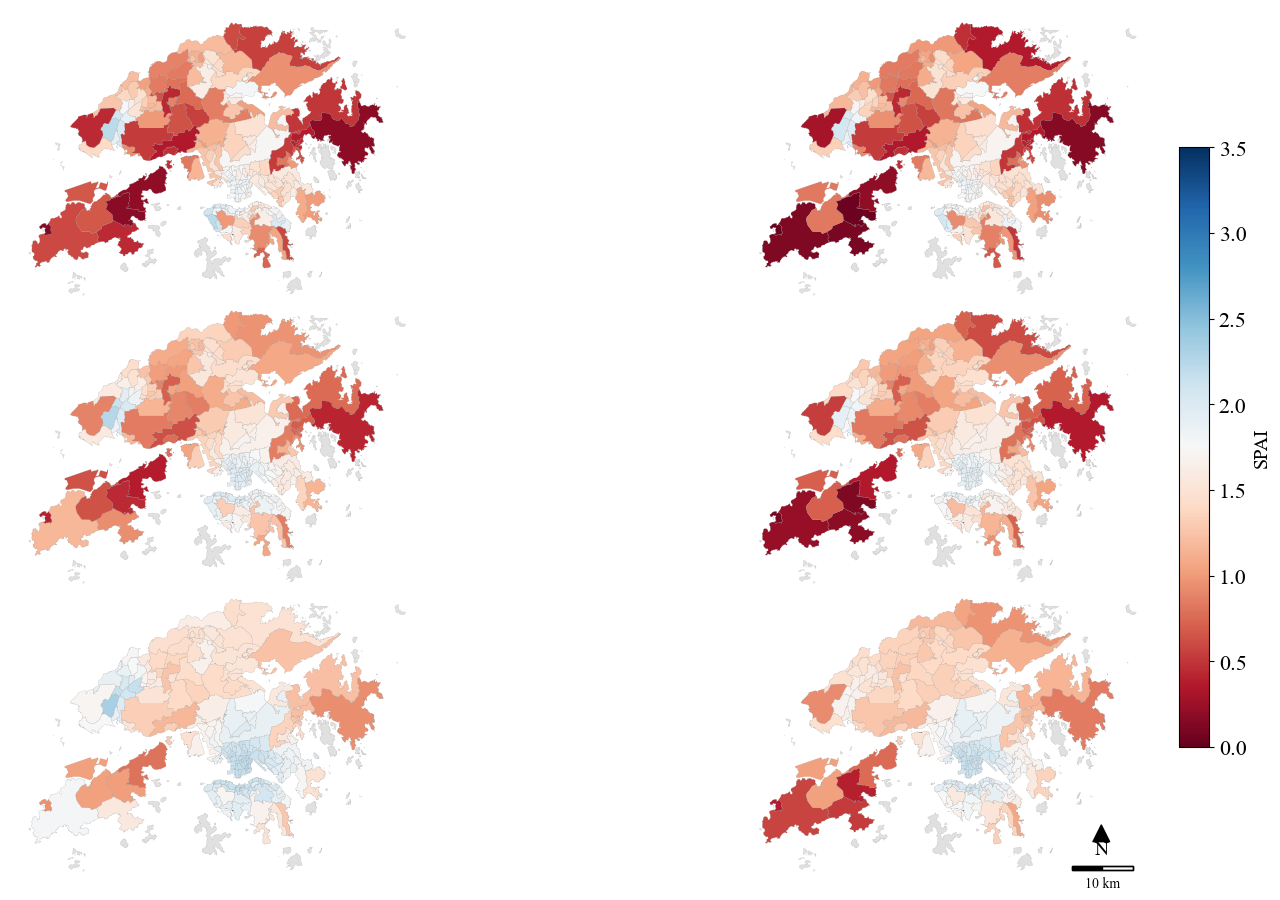

(<Figure size 1800x900 with 7 Axes>,
 [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >])

In [143]:
# Figure: Sensitivity analysis (SPAI)
col_ai23 = [
    "ai23_35_min", "ai23_75_min", 
    "ai23_35_mod", "ai23_75_mod",
    "ai23_35_high","ai23_75_high"
]

plot_ai_sens(ai_final, col_ai23, n_rows=3, n_cols=2, )

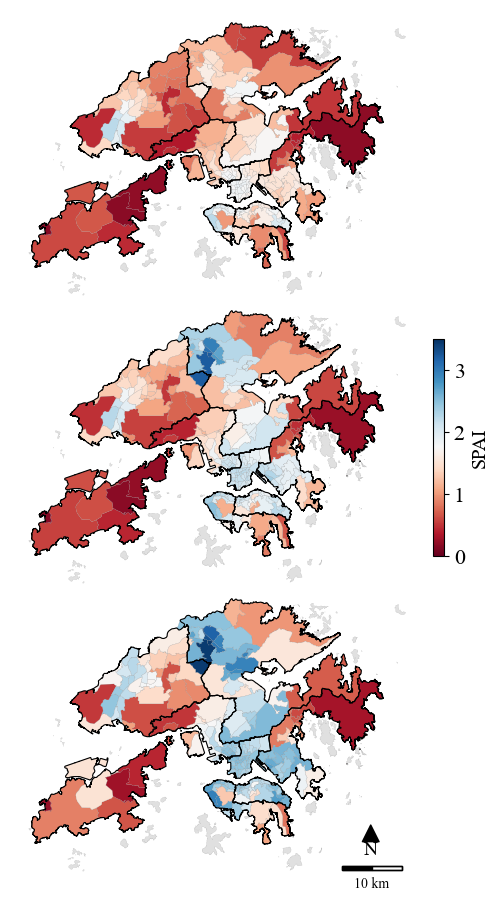

(<Figure size 1800x900 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >])

In [140]:
# Figure:  distribution of SPAI under scenarios
col_ai_scneario = [
    "ai23_35_min", 
    "ai27_35_min", 
    "ai36a_35_min",
]

plot_ai_sens(ai_final, col_ai_scneario, n_rows=3, n_cols=1, clusters=cluster)

In [58]:
# Result: 
ai_final.describe()

,ai23_35_min,ai23_35_mod,ai23_35_high,ai23_75_min,ai23_75_mod,ai23_75_high,ai27_35_min,ai36a_35_min
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,1.393587,1.554549,1.821544,1.344889,1.472452,1.698404,1.707984,2.041331
std,0.469724,0.411979,0.324562,0.472542,0.432537,0.376344,0.602426,0.651732
min,0.152697,0.374561,0.803660,0.036231,0.100713,0.371085,0.144854,0.225431
25%,1.136229,1.276390,1.555879,1.073688,1.212199,1.413385,1.289610,1.673255
50%,1.530182,1.655699,1.892592,1.485224,1.561339,1.733536,1.911621,2.265068
75%,1.765538,1.910623,2.113265,1.720796,1.828030,2.024435,2.119042,2.460038
max,2.222748,2.249655,2.337204,2.053460,1.990903,2.185469,3.203925,3.427124


### 2.2. Theil Index

In [59]:
# Function: Theil index
def theil_func(ai_df, pop_df,
               ai_col="ai23_35_min", stpug_col="stpug", pop_col="2023"):
    # 1. Reset ai_df index to column to ensure stpug_col is present
    df = ai_df.copy().reset_index()
    if ai_col != "Ai":
        df["Ai"] = df[ai_col]
    if stpug_col not in df.columns:
        df[stpug_col] = df.index

    # 2. Merge using pop_df's index (stpug) as key
    #    pop_df.index is assumed to be stpug identifiers
    df = df.merge(
        pop_df[[pop_col]],
        left_on=stpug_col,
        right_index=True,
        how="left"
    )

    # 3. Compute Theil index
    values = df["Ai"].astype(float).values
    weights = df[pop_col].astype(float).values
    total_weight = weights.sum()
    weighted_mean = (weights * values).sum() / total_weight

    # Avoid log(0) by replacing non-positive values
    safe_values = np.where(values > 0, values, 1e-10)
    ratios = safe_values / weighted_mean
    theil_index = np.sum(weights * ratios * np.log(ratios)) / total_weight

    return theil_index

In [60]:
# Calculation theil index
print(theil_func(ai_final, pop_ai, ai_col = "ai23_35_min", stpug_col="stpug", pop_col="2023"))
print(theil_func(ai_final, pop_ai, ai_col = "ai27_35_min", stpug_col="stpug", pop_col="2027"))
print(theil_func(ai_final, pop_ai, ai_col = "ai36a_35_min", stpug_col="stpug", pop_col="2036"))

0.03133066451194387
0.03967544387638756
0.02748503986171846


### 2.3. Optimization

#### 2.3.1 Analysis

In [61]:
# Function: greedy algorithm
def optimize_greedy(wij_df, trav_df, pop_df, hosp_df,
                    pop_col="2036", hosp_col="t_2028",
                    hosp_all_max=7820, hosp_limit_col="bed_limit",
                    tmax=35, alpha=8.34, beta=2.39,
                    min_avg_ai=1):
                    
    # Initialization
    if "cluster" not in hosp_df.columns:
        raise KeyError("'cluster' column not found in hosp_df.")
    hosp_df = hosp_df.copy()
    hosp_df.index = hosp_df.index.astype(str)
    hosp_current = hosp_df.copy()
    added_beds = pd.Series(0, index=hosp_current.index)


    # Bed limits
    if hosp_limit_col is None:
        bed_limits = pd.Series(hosp_all_max, index=hosp_current.index)
    else:
        if hosp_limit_col in hosp_current.columns:
            bed_limits = hosp_current[hosp_limit_col].astype(int).copy()
        else:
            raise KeyError(f"'{hosp_limit_col}' is not in hosp_df.")

    # Initial score 
    records = []
    ai_df0 = mh3sfca_func(
                trav_df=trav_df,
                pop_df=pop_df,
                hosp_df=hosp_current,
                wij_df=wij_df,
                tmax=tmax,
                alpha=alpha,
                beta=beta,
                pop_col=pop_col,
                supply_col=hosp_col
            )
    avg_ai0 = ai_df0["Ai"].mean()

    theil_val0 = theil_func(
                ai_df=ai_df0,
                pop_df=pop_df,
                ai_col="Ai",
                pop_col=pop_col,
                stpug_col="stpug"
            )
    records.append({
        "step": 0,
        "hosp": np.nan, 
        "cluster": np.nan,
        "avg_ai": avg_ai0,
        "theil": theil_val0,
        "hosp_additional_beds": 0
    })

    #Iteration
    for step in range(1, hosp_all_max + 1):
        best_hosp = None
        best_theil = np.inf
        best_avg_ai = None

        for j in hosp_current.index:
            # Skip if reached limit
            if added_beds[j] >= bed_limits[j]:
                continue

            # Try adding one bed
            hosp_current.at[j, hosp_col] += 1
            added_beds[j] += 1

            # Calculate accessibility index
            ai_df = mh3sfca_func(
                trav_df=trav_df,
                pop_df=pop_df,
                hosp_df=hosp_current,
                wij_df=wij_df,
                tmax=tmax,
                alpha=alpha,
                beta=beta,
                pop_col=pop_col,
                supply_col=hosp_col
            )
            avg_ai = ai_df["Ai"].mean()

            # Calculate Theil index
            theil_val = theil_func(
                ai_df=ai_df,
                pop_df=pop_df,
                ai_col="Ai",
                pop_col=pop_col,
                stpug_col="stpug"
            )

            # Revert trial change before selection
            hosp_current.at[j, hosp_col] -= 1
            added_beds[j] -= 1

            # Check threshold & handle tie
            if avg_ai >= min_avg_ai:
                if best_hosp is not None and theil_val == best_theil:
                    print(f"Tie detected between hospitals {best_hosp} and {j} at step {step}")
                    return pd.DataFrame(records)
                # Select if smaller Theil
                if theil_val < best_theil:
                    best_hosp = j
                    best_theil = theil_val
                    best_avg_ai = avg_ai

        # If no candidate met criteria, break loop
        if best_hosp is None:
            break

        # Apply best addition
        hosp_current.at[best_hosp, hosp_col] += 1
        added_beds[best_hosp] += 1

        # Record step
        cluster_value = hosp_df.loc[best_hosp, "cluster"]
        records.append({
            "step": step,
            "hosp": best_hosp,
            "cluster": cluster_value,
            "avg_ai": best_avg_ai,
            "theil": best_theil,
            "hosp_additional_beds": added_beds[best_hosp]
        })

    # Return results DataFrame
    result_df = pd.DataFrame(records)
    return result_df

In [62]:
# Set the Minimun threshold of average Ai 
avg_ai23 = ai_final["ai23_35_min"].mean()

WARNING: The following parts runs about 30 mintues. You can used the output in result file. 

In [63]:
# Setting 1: unlimited expansion limit for each hospital
"""
greedy_1 = optimize_greedy(wij27_35_min, trav_time_ai_27, pop_ai, hosp_ai,
                           pop_col="2036", hosp_col="t_2028", hosp_all_max=7820,
                           hosp_limit_col=None, tmax=35, alpha=8.34, beta=2.39, min_avg_ai=avg_ai23)
#greedy_1.to_csv("greedy_1_unlimited_c.csv", index=False)
"""

'\ngreedy_1 = optimize_greedy(wij27_35_min, trav_time_ai_27, pop_ai, hosp_ai,\n                           pop_col="2036", hosp_col="t_2028", hosp_all_max=7820,\n                           hosp_limit_col=None, tmax=35, alpha=8.34, beta=2.39, min_avg_ai=avg_ai23)\n#greedy_1.to_csv("greedy_1_unlimited_c.csv", index=False)\n'

In [64]:
# Setting 2: expansion limit for each hospital based on the 2nd 10-yeard HDP
"""
greedy_2 = optimize_greedy(wij27_35_min, trav_time_ai_27, pop_ai, hosp_ai,
                           pop_col="2036", hosp_col="t_2028", hosp_all_max=7820,
                           hosp_limit_col="dp_2036", tmax=35, alpha=8.34, beta=2.39, min_avg_ai=avg_ai23)
#greedy_2.to_csv("greedy_2_dp2_c.csv", index=False)
"""

'\ngreedy_2 = optimize_greedy(wij27_35_min, trav_time_ai_27, pop_ai, hosp_ai,\n                           pop_col="2036", hosp_col="t_2028", hosp_all_max=7820,\n                           hosp_limit_col="dp_2036", tmax=35, alpha=8.34, beta=2.39, min_avg_ai=avg_ai23)\n#greedy_2.to_csv("greedy_2_dp2_c.csv", index=False)\n'

#### 2.3.2. Visualization

If you did not run the previous optimization code, please used the following lines to input pre-computed results. If necessary, please replace with your own path.

In [65]:
greedy1 = pd.read_csv("./result/greedy_1_unlimited.csv")
greedy2 = pd.read_csv("./result/greedy_2_dp2.csv")

##### 2.3.2.1. Overall Averge Ai & Theil index

In [66]:
# Figure: optimization result (overall)
def plot_theil_avg_ai(df):

    plt.rcParams['font.family'] = 'Times New Roman'
    cols = ["step", "theil", "avg_ai"]
    df = df.dropna(subset=cols).sort_values("step").copy()
    x = df["step"].to_numpy()
    y_theil = df["theil"].to_numpy()
    y_ai = df["avg_ai"].to_numpy()

    fig, ax1 = plt.subplots(figsize=(16, 6))

    l_theil, = ax1.plot(x, y_theil, label="Theil Index", color="#B87A7A")
    ax1.set_xlabel("No. of additional beds", color="black", fontsize=16)
    ax1.set_ylabel("Theil Index", color="black", fontsize=16)
    ax1.set_ylim(0, 0.05)
    ax1.tick_params(axis="x", colors="black", labelsize=14)
    ax1.tick_params(axis="y", colors="black", labelsize=14)
    for s in ("bottom", "left", "top"):
        ax1.spines[s].set_color("black")

    ax2 = ax1.twinx()
    l_ai, = ax2.plot(x, y_ai, label="Average SPAI", color="#7A93B8")
    ax2.set_ylabel("Average SPAI", color="black", fontsize=16)
    ax2.set_ylim(0, 2.5)
    ax2.tick_params(axis="y", colors="black", labelsize=14)
    ax2.spines["right"].set_color("black")

    ax1.set_xlim(0, 8000)
    ax1.set_xticks(np.arange(0, 8001, 500))
    ax1.margins(x=0)
    plt.xticks(rotation=45, color="black")

    if len(x) > 0:
        idx_min = int(np.argmin(y_theil))
        step_min = int(x[idx_min])
        ax1.axvline(step_min, color="#888888", linestyle="--", linewidth=1.2, alpha=1)
        label_min = (
            f"No. of beds = {step_min}\n"
            f"Theil index = {y_theil[idx_min]:.4f}\n"
            f"Average SPAI = {y_ai[idx_min]:.3f}"
        )
        ax1.annotate(
            label_min,
            xy=(step_min, 0.92), xycoords=("data", "axes fraction"),
            xytext=(-8, 0), textcoords="offset points",
            ha="right", va="center", rotation=0, color="black", fontsize=14
        )

    handles = [l_theil, l_ai]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=14)

    #plt.title("Theil Index and Average SPAI over Steps", color="black")
    plt.subplots_adjust(right=0.82) 
    plt.show()


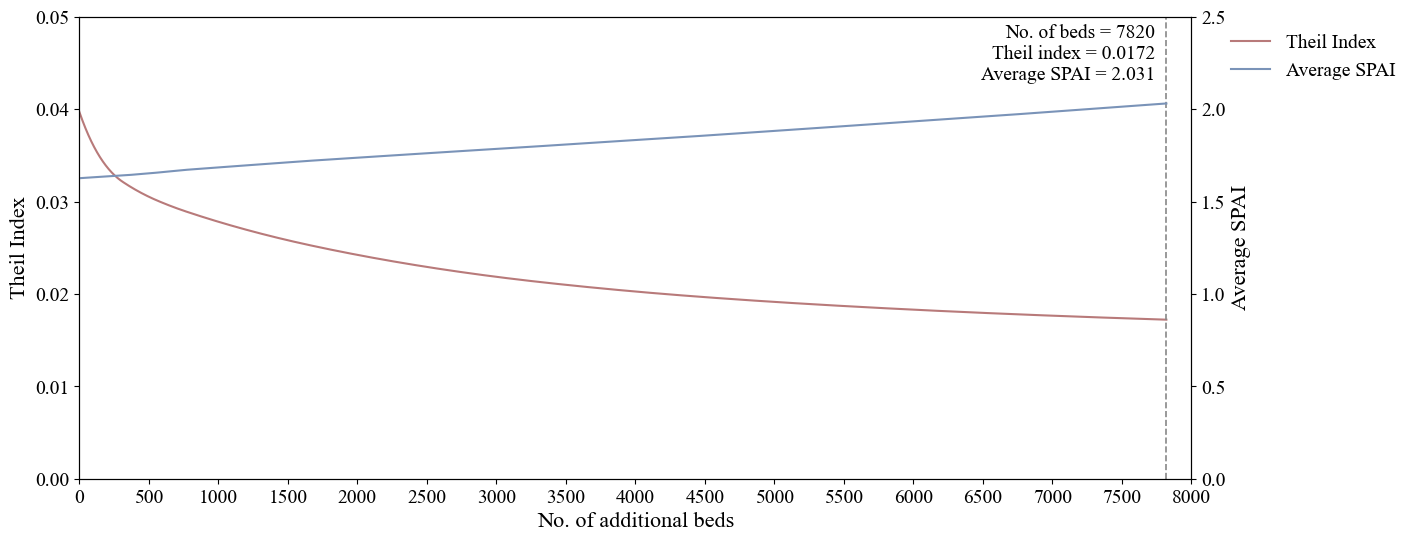

In [67]:
# Setting 1
plot_theil_avg_ai(greedy1)

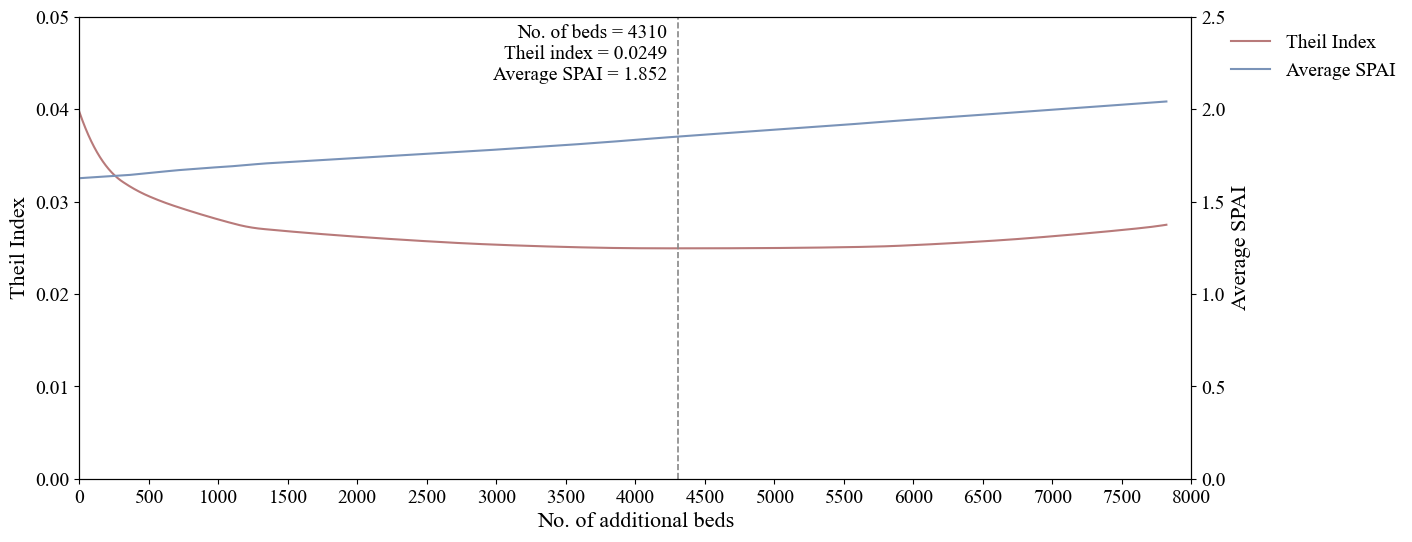

In [68]:
# Setting 2
plot_theil_avg_ai(greedy2)

##### 2.3.2.2. Hospital level

In [69]:
# Function: visualize optimization results at hospital level
def plot_cluster_cumfreq(df,
                         step_col="step", hosp_col="hosp", cluster_col="cluster",
                         step_max=7820,
                         x_axis_max=8000,
                         y_max=2500,
                         vline_steps=(7820),
                         marker_every=250):
    """
    where vline_steps is the number of step with minimum theil index
    """
    plt.style.use("default")
    plt.rcParams['font.family'] = 'Times New Roman'
    d = df[[step_col, hosp_col, cluster_col]].copy()
    d = d.dropna(subset=[step_col]).query(f"{step_col}>=0 & {step_col}<={step_max}")
    steps = np.arange(0, step_max + 1)

    d_nonan = d.dropna(subset=[hosp_col]).assign(appear=1)

    piv = d_nonan.pivot(index=step_col, columns=hosp_col, values="appear").reindex(steps)
    cum = piv.fillna(0).cumsum()

    first_step = d_nonan.groupby(hosp_col)[step_col].min().to_dict()

    hosp2cluster = (d_nonan[[hosp_col, cluster_col]]
                    .drop_duplicates(subset=[hosp_col])
                    .set_index(hosp_col)[cluster_col]).astype(str)

    row1 = ["hong kong east cluster",  "new territories east cluster", "kowloon east cluster"]
    row2 = ["hong kong west cluster", "new territories west cluster", "kowloon west cluster", "kowloon central cluster"]
    cluster_order = row1 + row2  # 7 panels; top-right is placeholder

    style_cycle = [
        {"linestyle": "-",  "marker": None},
        {"linestyle": "-",  "marker": "o"},
        {"linestyle": "-",  "marker": "^"},
        {"linestyle": "--", "marker": None},
    ]

    deep_red  = "#8B1A1A"

    fig, axes = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    # use the top-right panel as the placeholder
    placeholder_idx = 3
    plot_positions = [i for i in range(len(axes)) if i != placeholder_idx]

    # parse dashed-line steps
    red_step = None
    if isinstance(vline_steps, (list, tuple)) and len(vline_steps) >= 2:
        red_step  = vline_steps[1] 
    elif vline_steps is not None:
        red_step = vline_steps

    # draw each cluster (skip placeholder)
    for idx, cluster_name in enumerate(cluster_order):
        ax = axes[plot_positions[idx]]
        ax.set_facecolor("white")
        ax.grid(False)

        base_color = cluster_colors.get(cluster_name, "#666666")

        hosps = hosp2cluster[hosp2cluster.str.lower() == cluster_name.lower()].index.tolist()
        hosps_sorted = sorted(hosps, key=lambda h: (first_step.get(h, np.inf), str(h)))

        # no data -> hide panel
        if not hosps_sorted:
            ax.set_axis_off()
            continue

        for i, h in enumerate(hosps_sorted):
            if h not in cum.columns:
                continue
            st = style_cycle[i % len(style_cycle)]
            ax.plot(
                steps, cum[h].to_numpy(),
                color=base_color,
                linestyle=st["linestyle"],
                marker=st["marker"],
                markersize=4,
                markevery=marker_every if st["marker"] else None,
                linewidth=1.8,
                label=format_label(h, abbrev=False)
            )

        # axes & ticks
        ax.set_xlim(0, x_axis_max)
        ax.set_ylim(0, y_max)
        ax.xaxis.set_major_locator(MultipleLocator(1000))
        ax.xaxis.set_minor_locator(MultipleLocator(500))
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(which="major", length=6, labelsize=14)
        ax.tick_params(which="minor", length=3, labelsize=14)

        # vertical reference lines
        if red_step is not None:
            ax.axvline(red_step, color=deep_red, linestyle="--", linewidth=1.2)

        # abbreviated cluster title
        ax.set_title(format_label(cluster_name, abbrev=True), fontsize=20)

        # legend per subplot
        leg = ax.legend(fontsize=12, frameon=True, loc="upper left")
        leg.get_frame().set_facecolor((0.95, 0.95, 0.95, 0.75))
        leg.get_frame().set_edgecolor((0.6, 0.6, 0.6, 0.85))
        leg.get_frame().set_linewidth(0.8)

    # top-right placeholder: dashed-line legend
    ax_legend = axes[placeholder_idx]
    ax_legend.set_axis_off()
    handles, labels = [], []
    if red_step is not None:
        handles.append(Line2D([0], [0], color=deep_red, linestyle="--", linewidth=1.8))
        labels.append(f"Min Theil Index(beds = {int(red_step)})")
    if handles:
        leg2 = ax_legend.legend(handles, labels, loc="center", frameon=True, fontsize=20)
        leg2.get_frame().set_facecolor((0.95, 0.95, 0.95, 0.85))
        leg2.get_frame().set_edgecolor((0.6, 0.6, 0.6, 0.9))
        leg2.get_frame().set_linewidth(0.9)

    # --- professional axis labels (shared for the whole figure) ---
    fig.text(0.5, 0.04, "Total cumulative beds added (beds)",
             ha="center", va="center", fontsize=20)
    fig.text(0.06, 0.5, "Hospital-level cumulative beds added (beds)",
             ha="center", va="center", rotation="vertical", fontsize=20)

    # layout & export
    plt.tight_layout(rect=[0.08, 0.08, 1, 1])  # leave space for axis labels
    #plt.savefig("hosp_greedy1.png", dpi=1200, bbox_inches="tight")
    plt.show()


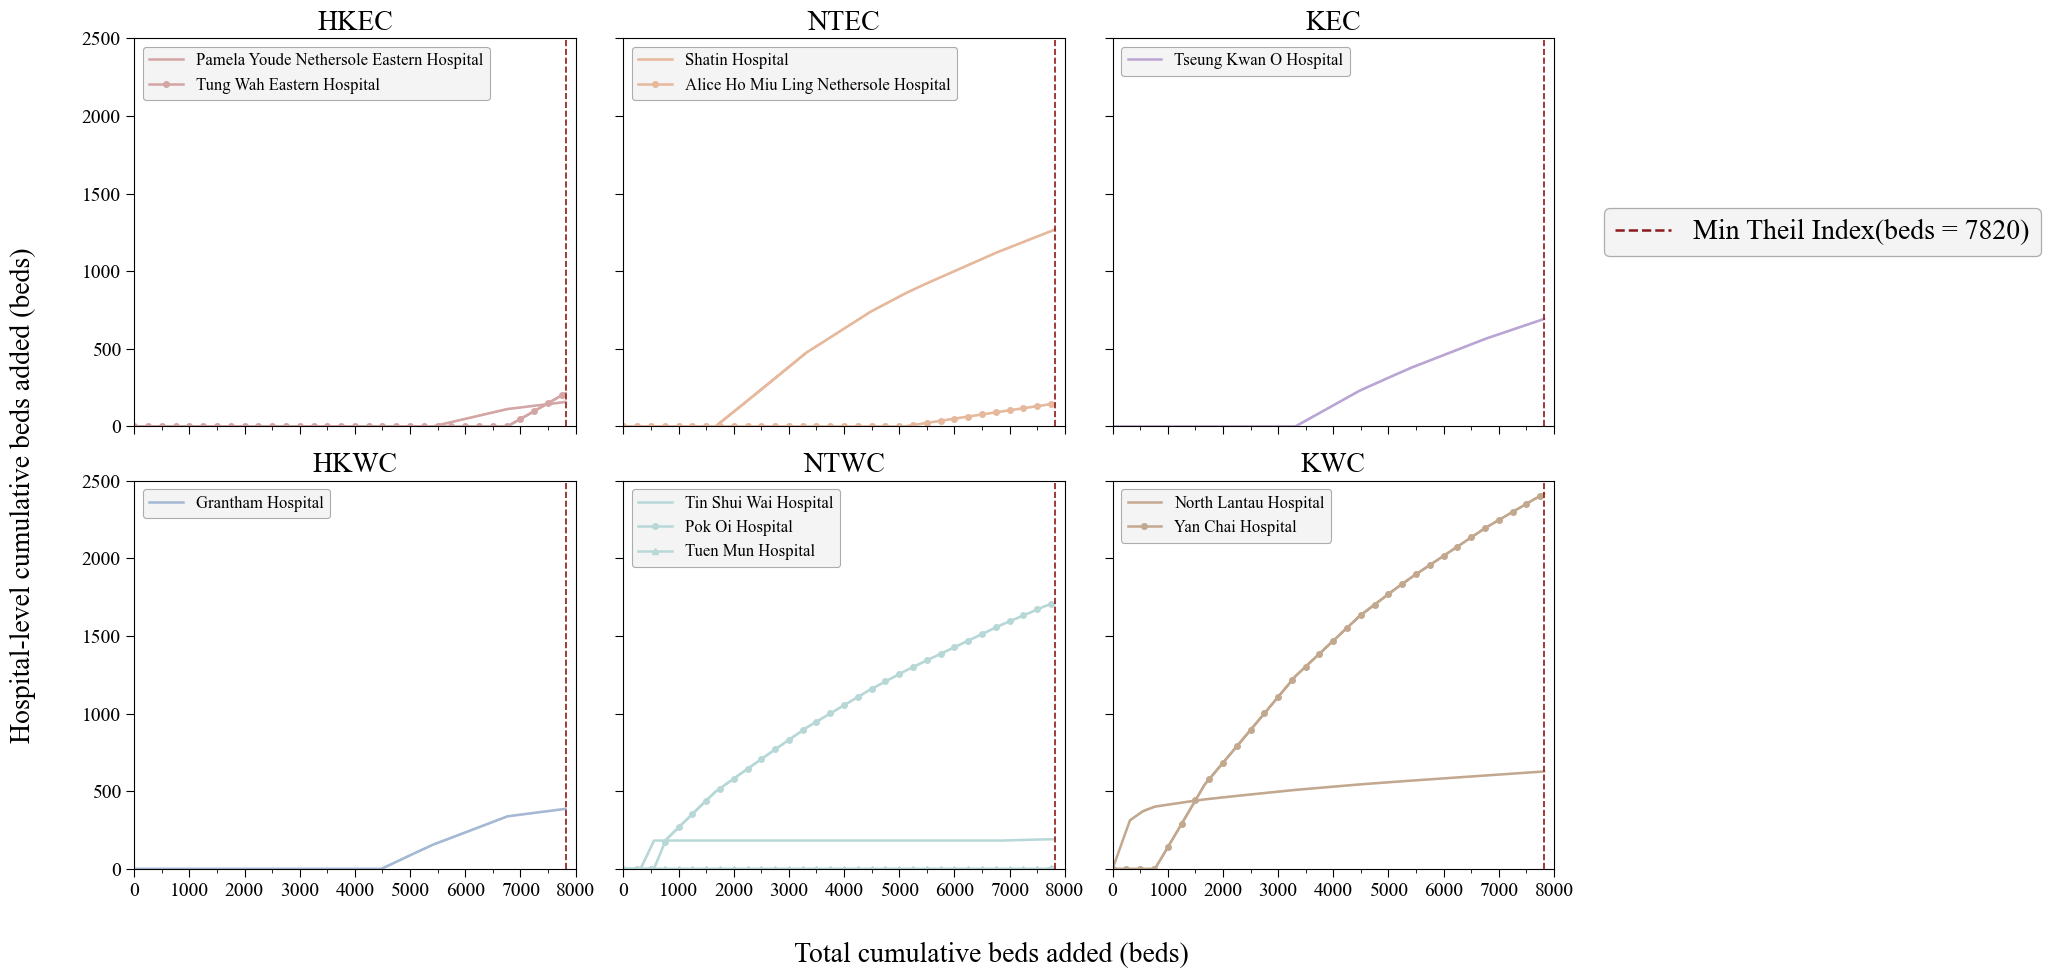

In [70]:
# Figure: setting 1
plot_cluster_cumfreq(greedy1, vline_steps=(7820))

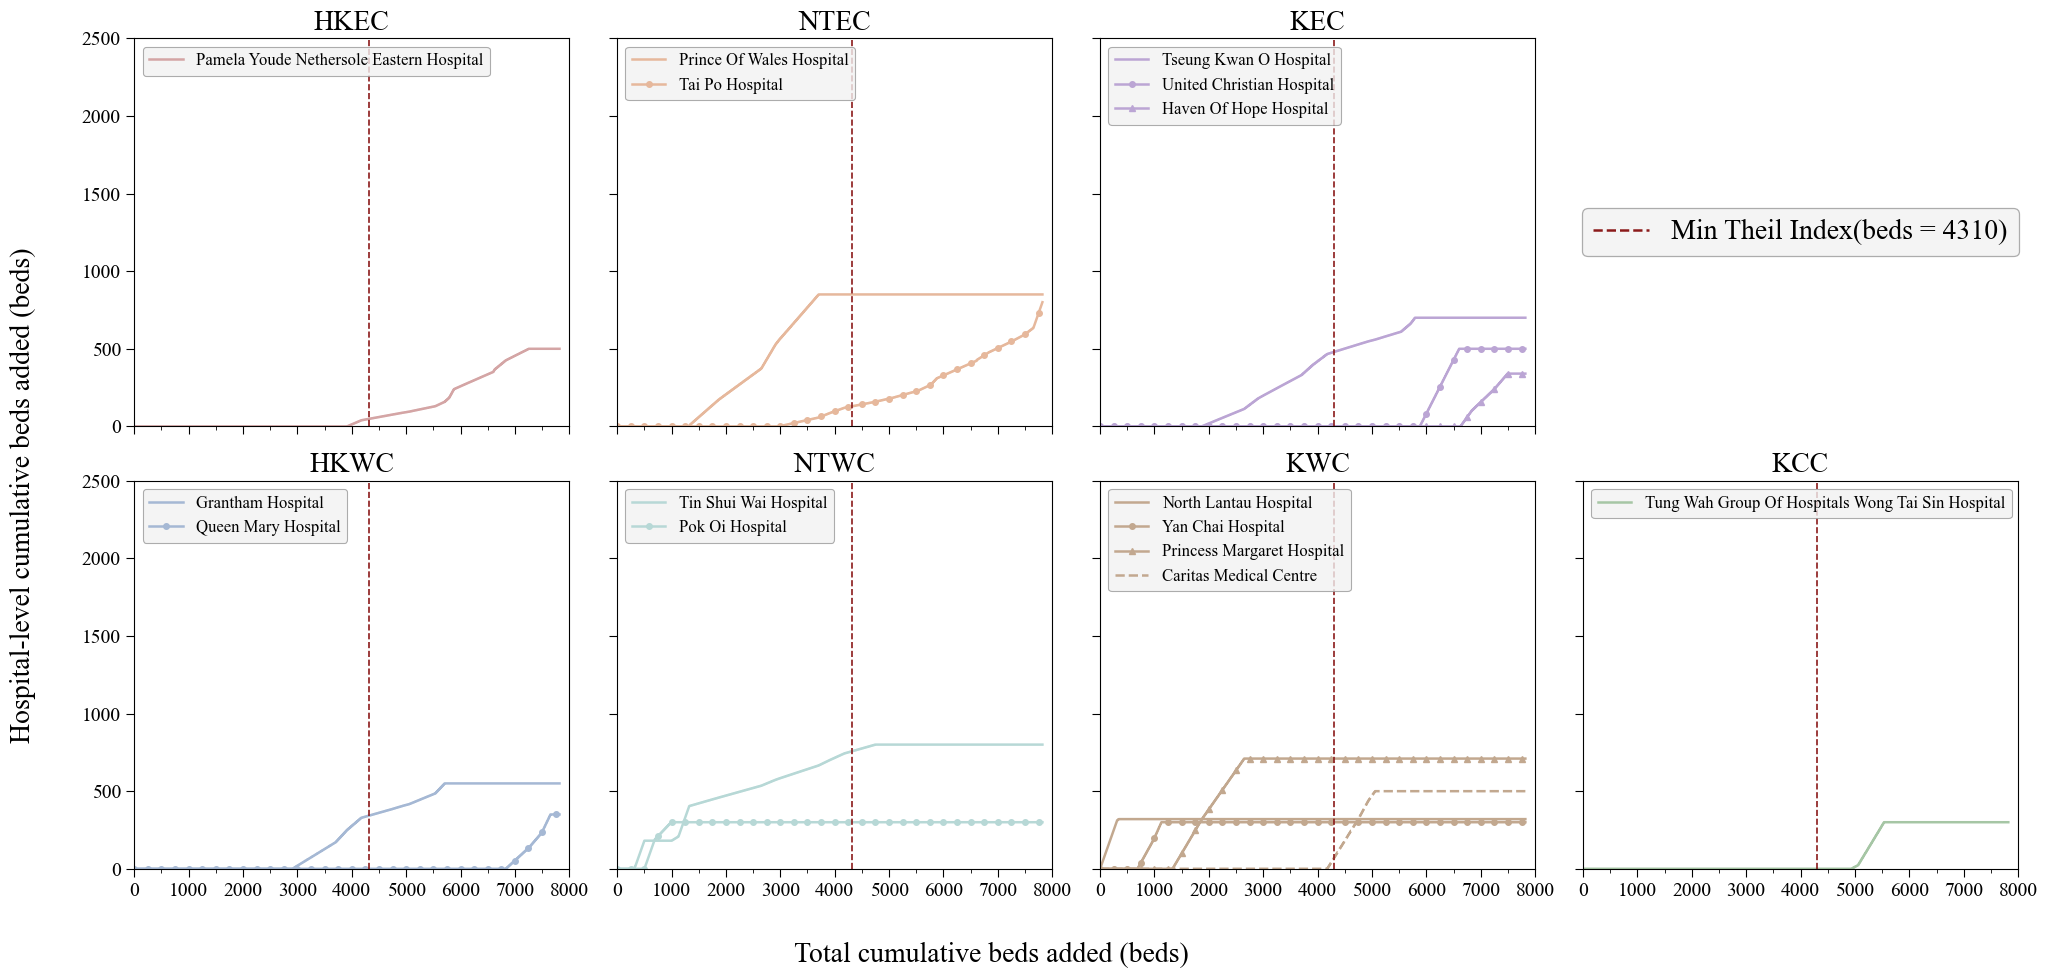

In [71]:
# Figure: setting 2
plot_cluster_cumfreq(greedy2, vline_steps=(4310))

In [98]:
# Function: to visualize the tuen mun hospital
def plot_single_hosp_cumfreq(df,
                             hosp_target="tuen mun hospital",
                             step_col="step", hosp_col="hosp", cluster_col="cluster",
                             y_max=11, x_back=5, tick_every=100, 
                             cluster_colors=None):
    assert cluster_colors is not None, "Please pass the `cluster_colors` dict."

    d = df[[step_col, hosp_col, cluster_col]].dropna(subset=[step_col]).copy()
    d[step_col] = d[step_col].astype(int)

    step_max = d[step_col].max()
    steps = np.arange(0, step_max + 1)

    d_nonan = d.dropna(subset=[hosp_col]).assign(appear=1)

    if hosp_target not in d_nonan[hosp_col].unique():
        raise ValueError(f"'{hosp_target}' not found in `{hosp_col}`.")

    piv = d_nonan.pivot(index=step_col, columns=hosp_col, values="appear").reindex(steps)
    cum = piv.fillna(0).cumsum()

    first_step = d_nonan.groupby(hosp_col)[step_col].min()
    target_cluster = d_nonan.loc[d_nonan[hosp_col] == hosp_target, cluster_col].dropna().iloc[0]
    base_color = cluster_colors.get(str(target_cluster), "#666666")

    hosps_in_cluster = (d_nonan.loc[d_nonan[cluster_col].astype(str).str.lower()
                         == str(target_cluster).lower(), hosp_col].unique().tolist())
    hosps_sorted = sorted(hosps_in_cluster, key=lambda h: (first_step.get(h, np.inf), str(h)))
    idx_in_cluster = hosps_sorted.index(hosp_target) if hosp_target in hosps_sorted else 0

    style_cycle = [
        {"linestyle": "-",  "marker": None},
        {"linestyle": "-",  "marker": "o"},
        {"linestyle": "-",  "marker": "^"},
        {"linestyle": "--", "marker": None},
    ]
    st = style_cycle[idx_in_cluster % len(style_cycle)]

    # markers only where cumulative increases
    y = cum[hosp_target].to_numpy()
    grow_idx = np.where(np.diff(y) > 0)[0] + 1
    if y[0] > 0:
        grow_idx = np.r_[0, grow_idx]

    first_s = int(first_step[hosp_target])
    x0, x1 = max(0, first_s - int(x_back)), int(step_max)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    ax.plot(
        steps, y,
        color=base_color,
        linestyle=st["linestyle"],
        marker=st["marker"],
        markevery=grow_idx if st["marker"] else None,
        markersize=4 if st["marker"] else 0,
        linewidth=2.0,
        label=hosp_target.title()
    )

    ax.set_xlim(x0, x1)
    ax.set_ylim(0, y_max)

    # x ticks: major every 20, minor every 10 (no labels)
    ax.xaxis.set_major_locator(MultipleLocator(tick_every))
    ax.xaxis.set_minor_locator(MultipleLocator(max(1, tick_every // 2)))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_xlabel("Total cummulative beds added (beds)", fontsize=12)
    ax.set_ylabel("Hospital-level cummulative beds added (beds)", fontsize=12)
    ax.set_title(hosp_target.title())
    #ax.legend(frameon=True, fontsize=9)

    plt.tight_layout()
    #plt.savefig("tmh.png", dpi=1200, bbox_inches="tight")
    plt.show()


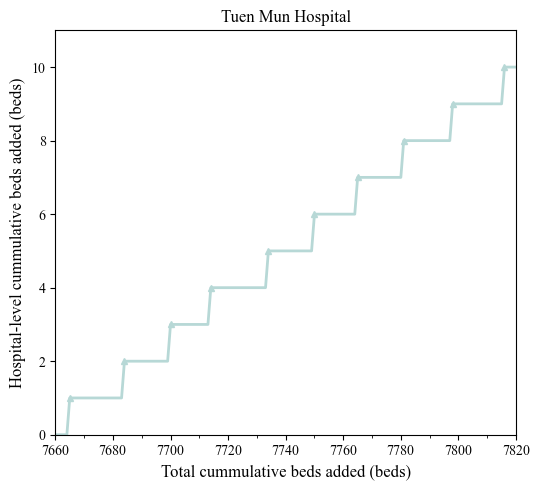

In [102]:
# Figure: TMH
plot_single_hosp_cumfreq(greedy1,
                         hosp_target="tuen mun hospital",
                         y_max=11, x_back=5, tick_every=20,
                         cluster_colors=cluster_colors)

### 2.4. Clustering

In [74]:
# Estimate flows under Scenario 3a
pij_final['flow_36a'] = pij_final["pij36a_35_min"] * pij_final["2036"]

In [75]:
# Function: plot dendrogram
def plot_hosp_dendrogram(df,
                         flow_col='flow_36a',
                         figsize=(12, 8),
                         ytick_step=0.2):
    # pivot → ratio → vector
    mat = df.pivot_table(index='hosp', columns='stpug',
                         values=flow_col, fill_value=0)
    X = normalize(mat.div(mat.sum(axis=1), axis=0), norm='l2')
    Z = linkage(X, method='average', metric='cosine')

    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(
    Z,
    labels=[format_label(h) for h in mat.index],
    leaf_rotation=90,
    ax=ax,
    color_threshold=0, 
    above_threshold_color='grey',
    link_color_func=lambda k: 'grey'
)

    hosp2cluster = (df[['hosp', 'cluster_hosp']]
                    .drop_duplicates()
                    .set_index('hosp')['cluster_hosp']
                    .str.lower()
                    .to_dict())
    for lbl in ax.get_xmajorticklabels():
        ckey = hosp2cluster.get(lbl.get_text().lower())
        if ckey:
            lbl.set_color(cluster_colors.get(ckey, 'black'))
            lbl.set_fontweight('bold')
            lbl.set_fontsize(12)

    handles = [plt.Line2D([0], [0], marker='s', linestyle='',
                          markersize=12, markerfacecolor=c)
               for c in cluster_colors.values()]
    ax.legend(handles,
              [format_label(n,abbrev=True) for n in cluster_colors.keys()],
              title='HA Cluster', bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=18,title_fontsize=18)

    ax.set_yticks(np.arange(0, 1.05, ytick_step))
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.tick_params(axis="y", labelsize=18)
    plt.tight_layout()
    return fig, ax, Z, X 

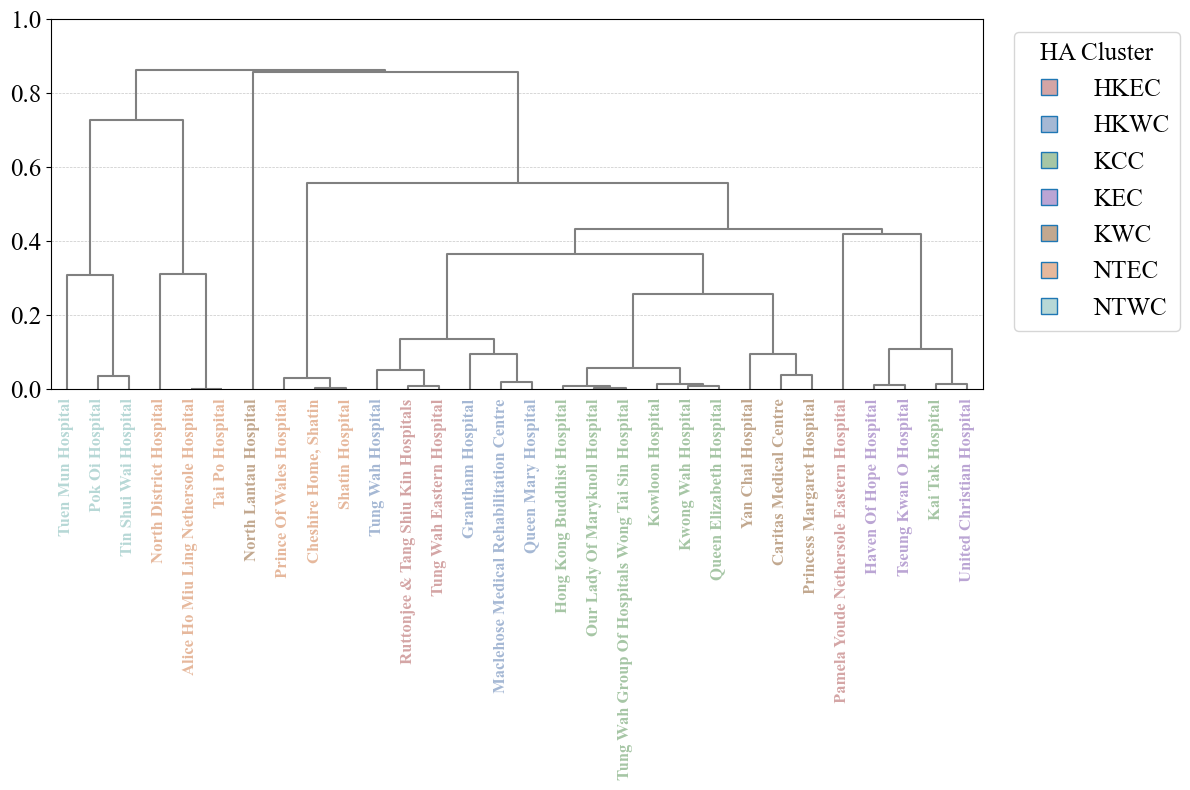

In [76]:
# Figure: dendrogram
fig, ax, Z, X = plot_hosp_dendrogram(pij_final)


In [77]:
# Function: extract result
def hosp_cluster_table(Z, X, idx, thresh_list=(0.2, 0.4, 0.6, 0.8)):
    cluster_df = pd.DataFrame(index=idx)
    for thr in thresh_list:
        labels = fcluster(Z, t=thr, criterion='distance')
        cluster_df[f'cosdis_{thr}'] = labels
    return cluster_df

In [78]:
cluster_result = hosp_cluster_table(Z, X, idx=pij_final['hosp'].unique(),
                              thresh_list=(0.2, 0.4, 0.6, 0.8))

In [79]:
# Merge cluster result with hospital ai
hosp_ai = hosp_ai.join(cluster_result)

In [80]:
# Functions: map clustering results
# 1: return linstring list about cosine distance and clusters
def _mst_edges_for_group(grp: gpd.GeoDataFrame):
    if len(grp) < 2:
        return []
    coords = np.array([[geom.x, geom.y] for geom in grp.geometry])
    edges = [(i, j, np.hypot(*(coords[i] - coords[j])))
             for i in range(len(coords)) for j in range(i+1, len(coords))]
    parent = list(range(len(coords)))
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(a,b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra
            return True
        return False
    edges_sorted = sorted(edges, key=lambda t: t[2])
    lines = []
    nodes = list(grp.index)
    for i,j,_ in edges_sorted:
        if union(i,j):
            p1 = grp.loc[nodes[i], 'geometry']
            p2 = grp.loc[nodes[j], 'geometry']
            lines.append(LineString([p1, p2]))
            if len(lines) == len(coords) - 1:
                break
    return lines

# 2: mapping
def plot_four_threshold_maps_by_column(
    hosp_ai: gpd.GeoDataFrame,
    cluster_gdf: gpd.GeoDataFrame,
    islands_gdf: gpd.GeoDataFrame,
    cluster_colors: dict,
    thresh_cols=('cosdis_0.2','cosdis_0.4','cosdis_0.6','cosdis_0.8'),
    figsize=(16, 12),
    point_size=40,
    line_width=2.5,
    line_alpha=0.9,
    method='mst'
):
    for col in thresh_cols:
        if col not in hosp_ai.columns:
            raise ValueError(f"缺少列：{col}")

    cluster_facecolors = cluster_gdf['cluster'].map(cluster_colors)

    legend_patches = [
        mpatches.Patch(color=clr, label=format_label(name, abbrev=True))
        for name, clr in cluster_colors.items()
    ]

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()

    for ax, col in zip(axes, thresh_cols):
        islands_gdf.plot(ax=ax, color='lightgrey', edgecolor='none', zorder=0)
        cluster_gdf.plot(ax=ax, color=cluster_facecolors, edgecolor='black',
                         alpha=0.5, linewidth=0.4, zorder=1)

        groups = hosp_ai[col].unique()
        cmap = cm.get_cmap("Set2", len(groups))
        cluster_line_color = {grp: cmap(i) for i, grp in enumerate(groups)}

        for grp_id, grp in hosp_ai.groupby(col):
            if len(grp) < 2:
                continue
            color = cluster_line_color[grp_id]
            if method == 'nearest':
                seen = set()
                for idx, row in grp.iterrows():
                    others = grp.drop(idx)
                    nearest_idx = others.distance(row.geometry).idxmin()
                    pair = tuple(sorted([idx, nearest_idx]))
                    if pair not in seen:
                        seen.add(pair)

                        ax.plot(
                            [row.geometry.x, grp.loc[nearest_idx].geometry.x],
                            [row.geometry.y, grp.loc[nearest_idx].geometry.y],
                            color="black", linewidth=line_width+1.5, alpha=line_alpha, zorder=2
                        )

                        ax.plot(
                            [row.geometry.x, grp.loc[nearest_idx].geometry.x],
                            [row.geometry.y, grp.loc[nearest_idx].geometry.y],
                            color=color, linewidth=line_width, alpha=line_alpha, zorder=3
                        )
            else:
                lines = _mst_edges_for_group(grp)
                for line in lines:
                    xs, ys = line.xy
                    ax.plot(xs, ys, color="black", linewidth=line_width+1.5, alpha=line_alpha, zorder=2)
                    ax.plot(xs, ys, color=color, linewidth=line_width, alpha=line_alpha, zorder=3)

        hosp_ai.plot(ax=ax, markersize=point_size, color='black',
                     edgecolor='white', linewidth=0.6, zorder=4)

        ax.set_title(f"Cosine Distance {col.split('_')[-1]}", fontsize=20)
        ax.set_axis_off()

    plt.subplots_adjust(right=0.80)

    fig.legend(
        handles=legend_patches,
        title='Cluster',
        loc='upper left',
        bbox_to_anchor=(0.82, 1.0),
        frameon=False,
        fontsize=18,
        title_fontsize=18
    )

    plt.tight_layout(rect=[0.0, 0.0, 0.84, 1.0])  
    add_north_arrow(ax, x=0.87, y=0.2, size=0.08, text_size=14, color='black')
    add_scale_bar(ax,length=10000,location=(0.8, 0.05)) 
    plt.show()

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2023628596.py:66: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2023628596.py:66: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2023628596.py:66: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/3q/2qxpflq54v78312ltmnxrmyr0000gn/T/ipykernel_5786/2023628596.py:66: 

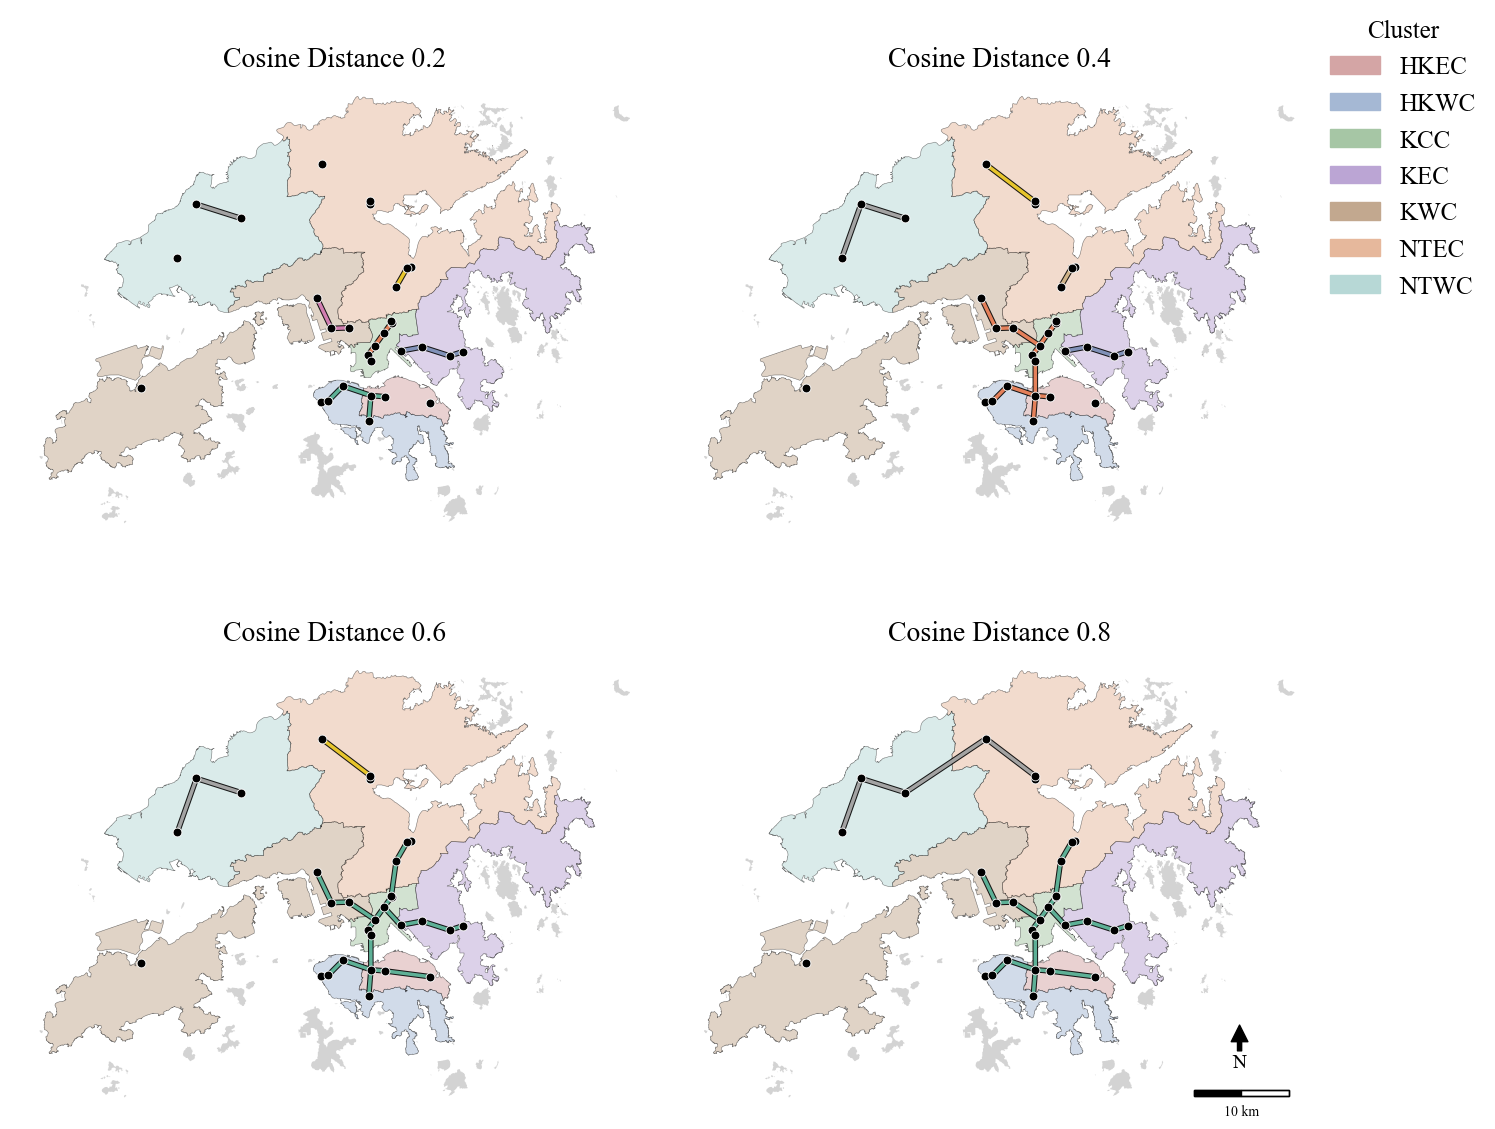

In [81]:
# Figure: clustering result map
plot_four_threshold_maps_by_column(
    hosp_ai=hosp_ai,
    cluster_gdf=cluster,
    islands_gdf=islands,
    cluster_colors=cluster_colors,
    thresh_cols=('cosdis_0.2','cosdis_0.4','cosdis_0.6','cosdis_0.8'),
    method='mst')